# Binary Prediction of Poisonous Mushrooms

In this kernel, we are going to apply machine learning techniques to create a model that predicts whether a mushroom is edible or poisonous based on its physical characteristics.

The dataset is provided in Kaggle used in their [competition](https://www.kaggle.com/competitions/playground-series-s4e8/overview).

Below is the outline of this kernel:

1. Importing Required Libraries
2. Self-Learning About Mushrooms
3. Understanding Evaluation Matric
3. Reading Data
4. EDA
    - Overview
    - Duplicated Values
    - Missing Values
    - Target Distribution
    - Categorical Features
    - Numerical Features
5. Feature Engineering
6. Preprocessing
7. Feature Importances
8. Modeling
9. Summary

# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, RandomizedSearchCV, StratifiedKFold
import warnings
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, matthews_corrcoef
import category_encoders as ce
from ucimlrepo import fetch_ucirepo
import optuna

# model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# Knowledge About Mushrooms

Source 1 - __[How to Identify Poisonous Mushrooms](https://www.youtube.com/watch?v=JobzTvnjitk&t=51s)__

- In general, you should avoid mashrooms that have white gills.
- You should also steer clear of mashrooms that have a ring around the stem and/or bulbous base which maybe above or below ground.
- Mashrooms with red on the stem or cap are also likely to be poisonous. 
- Poisonous mashrooms typically have an unpleasant smell but not always.
- There are many poisonous mushrooms without these characteristics.

Source 2 - __[Poisonous Mushrooms Identification (A Forager's Guide)](https://ecocation.org/poisonous-mushroom-identification/)__

- Cap Characteristics: Irregular or wrinkled caps may signal a poisonous variety. 
- Gill Structure: Be wary of mushrooms with white, red, or free gills.
- Spore Color: White, pink, or green spore prints are often telltale signs. 
- Stem Features: Bulbs or rings on the stem.
- Odor: A foul or unusual odor can be a warning.
- Location and Season: Poisonous mushrooms have preferred habitats and seasons.

Source 3 - __[How to Identify Poisonous Mushrooms](https://www.wikihow.com/Identify-Poisonous-Mushrooms)__

- _Amanita_ is a very common genus of mushroom, and some of the most toxic types of mushrooms belong in this group.
 - The majority of _Amanita_ mushrooms fall into the color range of red, orange, yellow, white, or grey. Some Amanita mushrooms also stain red if they are broken or bruised. <br>
 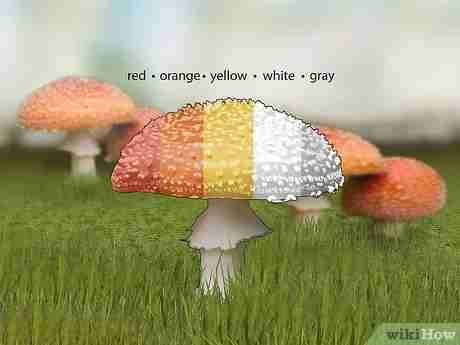
 - _Amanita_ mushrooms have a cap that looks like a very wide, upside down letter “U”. This cap shape can also be described as a parasol. <br>
 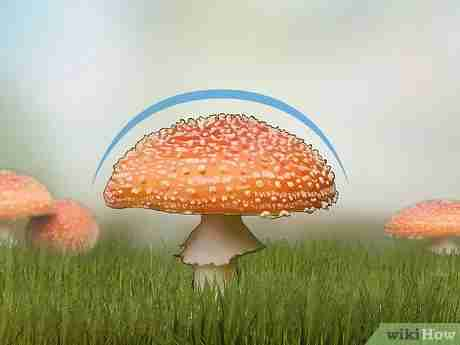
 - All _Amanita_ mushrooms have dry caps, which means that they don’t have a slimy or wet appearance like many other varieties. <br>
 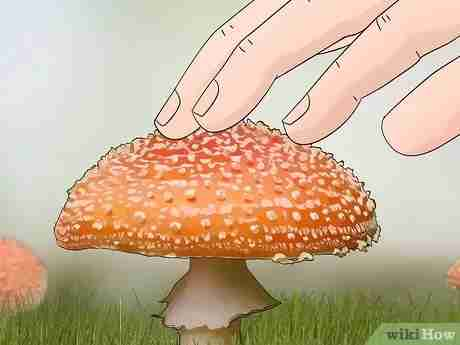
 - Many Amanita mushrooms have off-colored patches on the cap, which make the mushroom stand out. These could be slightly brown scales on white mushrooms, or white warts on red mushrooms. <br>
 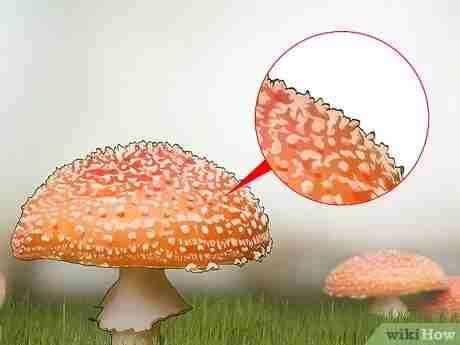
 - The base at the bottom of the stem will be a very rounded, cup shape. <br>
 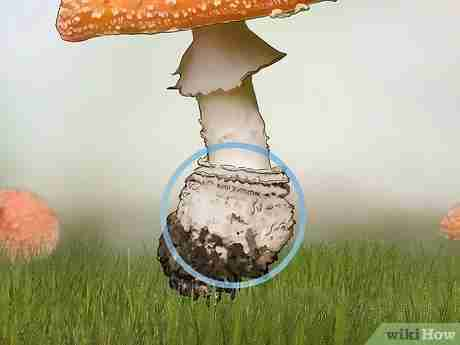
 - Many _Amanita_ mushrooms have a distinct ring around the stem. It is the same color as the stem, and it may not always be possible to spot. <br>
 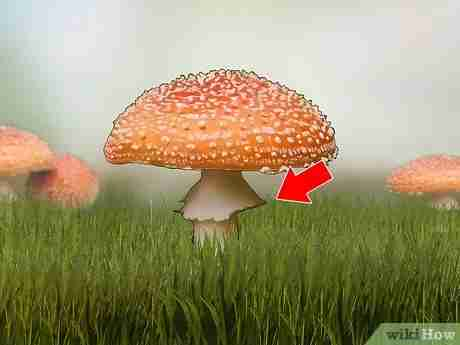
 - _Amanita_ mushrooms usually have white or very pale gills, which is an easy way to distinguish them as poisonous from other mushrooms. <br>
 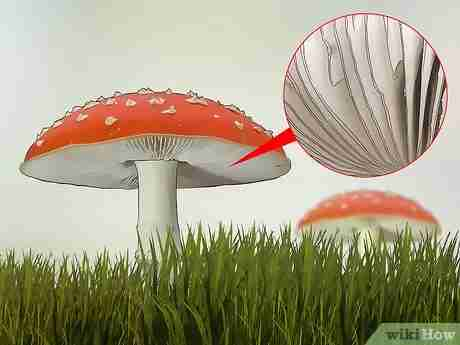
 - Most _Amanita_ has white spores. <br>
 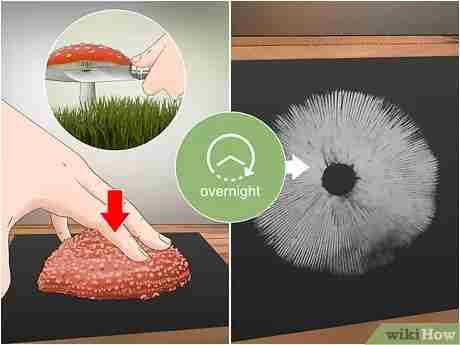
<br>
<br>
- False Morel vs. True Morel
 - True morels have a cap that is fully attached to the stem, whereas _false morels_ have a cap that freely hangs from the stem. If you slice the cap in half lengthwise and examine the cap interior, true morels will be completely hollow inside the cap, from the tip to the bottom of the cap which is attached to the stem. Contrastingly, false morels will have a dimpled appearance in the cap interior, which looks cotton-like and fibrous.
 - Furthermore, the cap of a true morel is usually uniform and longer than the stem, whereas the cap of a false morel is often irregular, looks squashed, and is shorter than the stem. <br>
 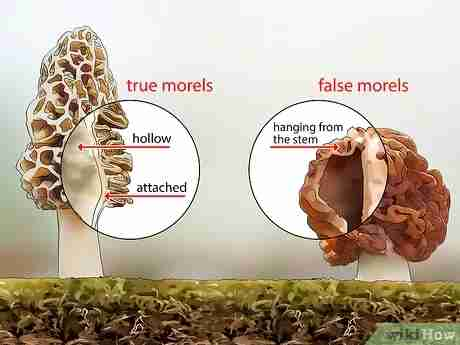
- Green-Spred Parasols vs. Shaggy Parasols
 - Both of these mushroom species look similar to the white button mushrooms that are found in supermarkets. The green-spored parasol is toxic and can have serious consequences if it's consumed, whereas the shaggy parasol is edible. The spore print of a green-spored parasol mushroom will be either green or grey, whereas a shaggy parasol will produce a cream spore print. In North America, the green-spored parasol is the most commonly consumed toxic species of mushroom. It usually grows during summer and fall, particularly after heavy rains. <br>
 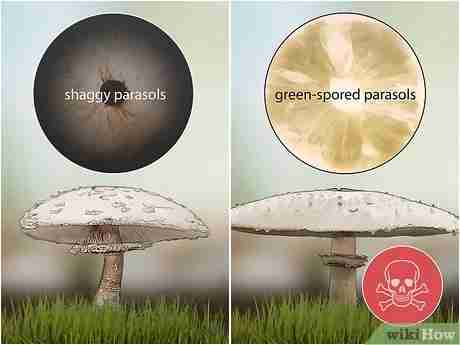
<br>
<br>
- Jack o'lantern vs. Chanterelles
 -  Chanterelle mushrooms have false gills which means that they cannot be separated from the cap without the gills breaking. Contrastingly, Jack o'lantern mushrooms have true gills, and these are forked, knife-like, and can be removed without damaging the cap.
 - Chanterelle gills also look as though they have melted.
 - The distribution of the mushrooms can also indicate the species. Chanterelles only grow near trees and don't grow in large groups. Jack o'lanterns grow in dense clusters and can grow where there are no trees, such as in the middle of a field. <br>
 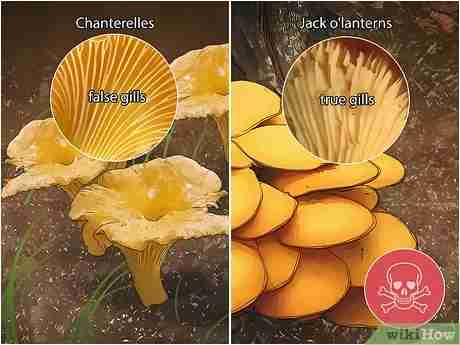
<br>
<br>
- _Galerina_ vs. Honey Mushrooms
 - The safe, edible honey mushrooms produce a white spore print, while deadly _Galerina_ mushrooms give a spore print that's rusty brown. 
 - Honey mushrooms also tend to have a larger veil than _Galerina_ mushrooms.
 - These mushroom species look very alike and often grow in similar locations, such as along the same tree stump. <br>
 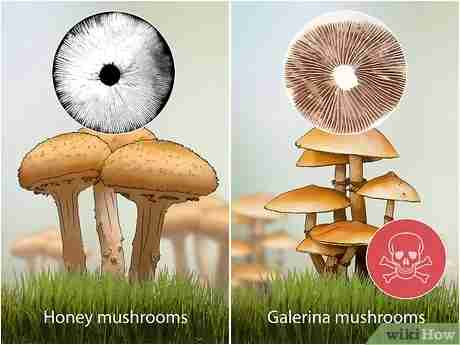

# Understanding Evaluation Matric

In this competition, models are evaluated using the _Matthews Correlation Coefficient (MCC)_. The MCC takes into account true and false positives and negatives, providing a balanced measure even when the classes are of very different sizes. While this dataset is fairely balanced between positive and negative classes, the MCC is particularly useful when you have an imbalanced dataset.

#### Formula:

$$
\text{MCC} = \frac{(TP \times TN) - (FP \times FN)}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

Where:
- **TP** = True Positives (correctly predicted positive instances)
- **TN** = True Negatives (correctly predicted negative instances)
- **FP** = False Positives (incorrectly predicted positive instances)
- **FN** = False Negatives (incorrectly predicted negative instances)

#### Key Points:
- **Range:** MCC values range from -1 to 1.
  - **1** indicates a perfect prediction.
  - **0** indicates random guessing.
  - **-1** indicates total disagreement between prediction and observation.
  
  
We will use scikit-learn's ``matthews_corrcoef`` function throughout the kernel.

# Reading Data
The features in this dataset provided in the competition correspond to the features explained in [this database](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset). I will use both the original dataset and the Kaggle dataset.

In [2]:
original = fetch_ucirepo(id=848)['data']['original']
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(f'original size: {original.shape}')
print(f'train size: {train.shape}')
print(f'test size: {test.shape}')

original size: (61069, 21)
train size: (3116945, 22)
test size: (2077964, 21)


# EDA
## Overview

In [4]:
original_df = original.copy()

train_df = train.copy()
train_df = train_df.drop('id', axis = 1)

test_df = test.copy()
test_df = test_df.drop('id', axis = 1)

In [5]:
train_df.head()

class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     e          8.80         f           s         u                    f   
1     p          4.51         x           h         o                    f   
2     e          6.94         f           s         b                    f   
3     e          3.88         f           y         g                    f   
4     e          5.85         x           l         w                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               a            c          w         4.51  ...        NaN   
1               a            c          n         4.79  ...        NaN   
2               x            c          w         6.85  ...        NaN   
3               s          NaN          g         4.16  ...        NaN   
4               d          NaN          w         3.37  ...        NaN   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0          NaN          w       NaN        NaN        f         f   
1            y          o       NaN        NaN        t         z   
2            s          n       NaN        NaN        f         f   
3          NaN          w       NaN        NaN        f         f   
4          NaN          w       NaN        NaN        f         f   

  spore-print-color habitat season  
0               NaN       d      a  
1               NaN       d      w  
2               NaN       l      w  
3               NaN       d      u  
4               NaN       g      a  

[5 rows x 21 columns]

In [6]:
train_df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   class                 3116945 non-null  object 
 1   cap-diameter          3116941 non-null  float64
 2   cap-shape             3116905 non-null  object 
 3   cap-surface           2445922 non-null  object 
 4   cap-color             3116933 non-null  object 
 5   does-bruise-or-bleed  3116937 non-null  object 
 6   gill-attachment       2593009 non-null  object 
 7   gill-spacing          1858510 non-null  object 
 8   gill-color            3116888 non-null  object 
 9   stem-height           3116945 non-null  float64
 10  stem-width            3116945 non-null  float64
 11  stem-root             359922 non-null   object 
 12  stem-surface          1136084 non-null  object 
 13  stem-color            3116907 non-null  object 
 14  veil-type             159452 non-n

In [7]:
train_df.describe().T.round(3)

count    mean    std   min   25%   50%    75%     max
cap-diameter  3116941.0   6.310  4.658  0.03  3.32  5.75   8.24   80.67
stem-height   3116945.0   6.348  2.700  0.00  4.67  5.88   7.41   88.72
stem-width    3116945.0  11.154  8.095  0.00  4.97  9.65  15.63  102.90

In [8]:
train_df.describe(include = "O").T

count unique top     freq
class                 3116945      2   p  1705396
cap-shape             3116905     74   x  1436026
cap-surface           2445922     83   t   460777
cap-color             3116933     78   n  1359542
does-bruise-or-bleed  3116937     26   f  2569743
gill-attachment       2593009     78   a   646034
gill-spacing          1858510     48   c  1331054
gill-color            3116888     63   w   931538
stem-root              359922     38   b   165801
stem-surface          1136084     60   s   327610
stem-color            3116907     59   w  1196637
veil-type              159452     22   u   159373
veil-color             375998     24   w   279070
has-ring              3116921     23   f  2368820
ring-type             2988065     40   f  2477170
spore-print-color      267263     32   k   107310
habitat               3116900     52   d  2177573
season                3116945      4   a  1543321

It seems that many features contain noise. To clean up the data, I will only allow categories present in the original data and group all other categories not seen in the original data as one category: ``na``.

In [9]:
org_features = test_df.columns.tolist()
num_features = ['cap-diameter', 'stem-height', 'stem-width']
cat_features = test.select_dtypes('object')

for feature in cat_features:
    unique_cat = original_df[feature].dropna().unique().tolist()
    dtype = pd.CategoricalDtype(categories = unique_cat, ordered = False)
    print(f"{feature}: {len(dtype.categories)} unique values")
    # training set
    train_df.loc[~train_df[feature].isin(unique_cat), feature] = np.NaN 
    train_df[feature] = train_df[feature].astype(dtype).cat.add_categories('na')
    original_df[feature] = original_df[feature].astype(dtype).cat.add_categories('na')
    # test set
    test_df.loc[~test_df[feature].isin(unique_cat), feature] = np.NaN 
    test_df[feature] = test_df[feature].astype(dtype).cat.add_categories('na')

for feature in ['cap-diameter', 'stem-height', 'stem-width']:
    dtype = np.float32
    # training set
    train_df[feature] = train_df[feature].astype(dtype)
    original_df[feature] = original_df[feature].astype(dtype)
    # test set
    test_df[feature] = test_df[feature].astype(dtype)

cap-shape: 7 unique values
cap-surface: 11 unique values
cap-color: 12 unique values
does-bruise-or-bleed: 2 unique values
gill-attachment: 7 unique values
gill-spacing: 3 unique values
gill-color: 12 unique values
stem-root: 5 unique values
stem-surface: 8 unique values
stem-color: 13 unique values
veil-type: 1 unique values
veil-color: 6 unique values
has-ring: 2 unique values
ring-type: 8 unique values
spore-print-color: 7 unique values
habitat: 8 unique values
season: 4 unique values


In [10]:
train_df = pd.concat([train_df, original_df]).reset_index(drop = True)
train_df

class  cap-diameter cap-shape cap-surface cap-color  \
0           e          8.80         f           s         u   
1           p          4.51         x           h         o   
2           e          6.94         f           s         b   
3           e          3.88         f           y         g   
4           e          5.85         x           l         w   
...       ...           ...       ...         ...       ...   
3178009     p          1.18         s           s         y   
3178010     p          1.27         f           s         y   
3178011     p          1.27         s           s         y   
3178012     p          1.24         f           s         y   
3178013     p          1.17         s           s         y   

        does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
0                          f               a            c          w   
1                          f               a            c          n   
2                          f               x            c          w   
3                          f               s          NaN          g   
4                          f               d          NaN          w   
...                      ...             ...          ...        ...   
3178009                    f               f            f          f   
3178010                    f               f            f          f   
3178011                    f               f            f          f   
3178012                    f               f            f          f   
3178013                    f               f            f          f   

         stem-height  ...  stem-root stem-surface stem-color veil-type  \
0               4.51  ...        NaN          NaN          w       NaN   
1               4.79  ...        NaN            y          o       NaN   
2               6.85  ...        NaN            s          n       NaN   
3               4.16  ...        NaN          NaN          w       NaN   
4               3.37  ...        NaN          NaN          w       NaN   
...              ...  ...        ...          ...        ...       ...   
3178009         3.93  ...        NaN          NaN          y       NaN   
3178010         3.18  ...        NaN          NaN          y       NaN   
3178011         3.86  ...        NaN          NaN          y       NaN   
3178012         3.56  ...        NaN          NaN          y       NaN   
3178013         3.25  ...        NaN          NaN          y       NaN   

        veil-color has-ring ring-type spore-print-color habitat season  
0              NaN        f         f               NaN       d      a  
1              NaN        t         z               NaN       d      w  
2              NaN        f         f               NaN       l      w  
3              NaN        f         f               NaN       d      u  
4              NaN        f         f               NaN       g      a  
...            ...      ...       ...               ...     ...    ...  
3178009        NaN        f         f               NaN       d      a  
3178010        NaN        f         f               NaN       d      a  
3178011        NaN        f         f               NaN       d      u  
3178012        NaN        f         f               NaN       d      u  
3178013        NaN        f         f               NaN       d      u  

[3178014 rows x 21 columns]

## Duplicated Values

In [11]:
train_df.loc[train_df.duplicated()]

class  cap-diameter cap-shape cap-surface cap-color  \
2868442     p          1.51         x         NaN         n   
2938919     p          2.18         b         NaN         n   
3126808     p          1.14         x           g         w   
3129923     p          0.72         x           g         y   
3173471     p          4.27         o           s         n   
...       ...           ...       ...         ...       ...   
3175182     p          2.94         o           l         g   
3175184     p          3.30         o           l         g   
3175186     p          3.13         o           l         g   
3175187     p          2.83         o           l         g   
3175189     p          3.18         o           l         g   

        does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
2868442                    f             NaN          NaN          n   
2938919                    f               a          NaN          g   
3126808                    f               a            d          w   
3129923                    f             NaN          NaN          y   
3173471                    f             NaN            c          w   
...                      ...             ...          ...        ...   
3175182                    f               f            f          f   
3175184                    f               f            f          f   
3175186                    f               f            f          f   
3175187                    f               f            f          f   
3175189                    f               f            f          f   

         stem-height  ...  stem-root stem-surface stem-color veil-type  \
2868442         5.05  ...        NaN            s          n       NaN   
2938919         5.13  ...        NaN            s          g       NaN   
3126808         3.13  ...        NaN          NaN          e       NaN   
3129923         3.51  ...        NaN          NaN          y       NaN   
3173471         0.00  ...          f            f          f       NaN   
...              ...  ...        ...          ...        ...       ...   
3175182         0.00  ...          f            f          f       NaN   
3175184         0.00  ...          f            f          f       NaN   
3175186         0.00  ...          f            f          f       NaN   
3175187         0.00  ...          f            f          f       NaN   
3175189         0.00  ...          f            f          f       NaN   

        veil-color has-ring ring-type spore-print-color habitat season  
2868442        NaN        f         f                 k       g      a  
2938919        NaN        f         f               NaN       d      u  
3126808        NaN        f         f               NaN       d      u  
3129923        NaN        f         f               NaN       d      u  
3173471        NaN        f         f                 n       d      u  
...            ...      ...       ...               ...     ...    ...  
3175182        NaN        f         f               NaN       d      u  
3175184        NaN        f         f               NaN       d      u  
3175186        NaN        f         f               NaN       d      w  
3175187        NaN        f         f               NaN       d      u  
3175189        NaN        f         f               NaN       d      a  

[148 rows x 21 columns]

In [12]:
train_df.drop_duplicates(inplace = True)

In [13]:
train_df.loc[train_df.duplicated()]

Empty DataFrame
Columns: [class, cap-diameter, cap-shape, cap-surface, cap-color, does-bruise-or-bleed, gill-attachment, gill-spacing, gill-color, stem-height, stem-width, stem-root, stem-surface, stem-color, veil-type, veil-color, has-ring, ring-type, spore-print-color, habitat, season]
Index: []

[0 rows x 21 columns]

## Missing Values

In [14]:
train_n_missing_values = train_df.isna().sum()
train_prop_missing_values = train_df.isna().sum() / len(train_df)
test_n_missing_values = test_df.isna().sum()
test_prop_missing_values = test_df.isna().sum() / len(test_df)

df_missing_values = pd.DataFrame({'train_n_missing_values': train_n_missing_values, 
                                  'train_prop_missing_values': train_prop_missing_values,
                                  'test_n_missing_values': test_n_missing_values, 
                                  'test_prop_missing_values': test_prop_missing_values}).sort_values('train_prop_missing_values', ascending=False).round(5)

df_missing_values

train_n_missing_values  train_prop_missing_values  \
veil-type                            3015316                    0.94885   
spore-print-color                    2904452                    0.91396   
stem-root                            2808740                    0.88384   
veil-color                           2794596                    0.87939   
stem-surface                         2019379                    0.63545   
gill-spacing                         1283639                    0.40393   
cap-surface                           685743                    0.21579   
gill-attachment                       534291                    0.16813   
ring-type                             131751                    0.04146   
cap-shape                                567                    0.00018   
gill-color                               492                    0.00015   
habitat                                  492                    0.00015   
cap-color                                367                    0.00012   
stem-color                               296                    0.00009   
has-ring                                 143                    0.00004   
does-bruise-or-bleed                     117                    0.00004   
cap-diameter                               4                    0.00000   
season                                     0                    0.00000   
stem-height                                0                    0.00000   
stem-width                                 0                    0.00000   
class                                      0                    0.00000   

                      test_n_missing_values  test_prop_missing_values  
veil-type                         1971591.0                   0.94881  
spore-print-color                 1899728.0                   0.91423  
stem-root                         1838125.0                   0.88458  
veil-color                        1826228.0                   0.87885  
stem-surface                      1321738.0                   0.63607  
gill-spacing                       839680.0                   0.40409  
cap-surface                        447295.0                   0.21526  
gill-attachment                    350143.0                   0.16850  
ring-type                           86437.0                   0.04160  
cap-shape                             368.0                   0.00018  
gill-color                            328.0                   0.00016  
habitat                               309.0                   0.00015  
cap-color                             281.0                   0.00014  
stem-color                            208.0                   0.00010  
has-ring                              113.0                   0.00005  
does-bruise-or-bleed                   75.0                   0.00004  
cap-diameter                            7.0                   0.00000  
season                                  0.0                   0.00000  
stem-height                             1.0                   0.00000  
stem-width                              0.0                   0.00000  
class                                   NaN                       NaN

Many features, especially ``veil-type``, ``spore-print-color``, ``stem-root``, ``veil-color``, contain missing values. While it is common to drop features with a high number of missing values, I learned in the 'Self-Learning About Mushrooms' section that features like ``spore-print-color`` often help distinguish poisonous mushrooms. While I am not sure if veil-related features have any predictive powers, I will keep all features for now.

## Target Distribution

In [15]:
print(train['class'].value_counts())
print('--------------------------------')
print(train['class'].value_counts(normalize = True).round(3))

p    1705396
e    1411549
Name: class, dtype: int64
--------------------------------
p    0.547
e    0.453
Name: class, dtype: float64


The target variable in this dataset is fairly balanced.

## Categorical Features

In [16]:
cat_features = train_df.select_dtypes('category').columns
cat_features

Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [17]:
train_df['class'] = train_df['class'].map({'p':1, 'e':0})
original_df['class'] = original_df['class'].map({'p':1, 'e':0})

In [18]:
train_df[cat_features] = train_df[cat_features].fillna('na')
test_df[cat_features] = test_df[cat_features].fillna('na')

In [19]:
warnings.filterwarnings("ignore", category=FutureWarning)

Feature Name: cap-shape
----------------------------
             count     class
cap-shape                   
x          1462957  0.510325
f           689642  0.512002
s           372310  0.549276
b           324339  0.773142
o           112151  0.677069
p           109565  0.457920
c           106335  0.543302
na             567  0.557319


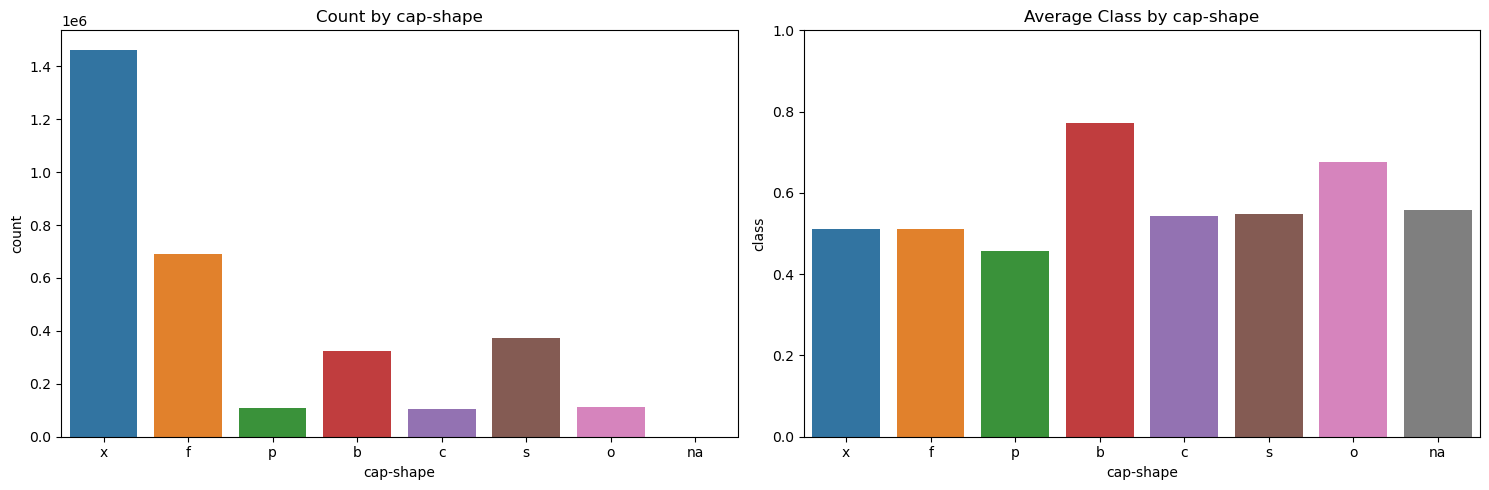

Feature Name: cap-surface
----------------------------
              count     class
cap-surface                  
na           685743  0.514149
t            468961  0.642616
s            392550  0.370470
y            334167  0.462230
h            289434  0.470194
g            268451  0.596954
d            211264  0.586830
k            131178  0.901904
e            122296  0.479345
i            115665  0.822150
w            111990  0.652978
l             46167  0.429701


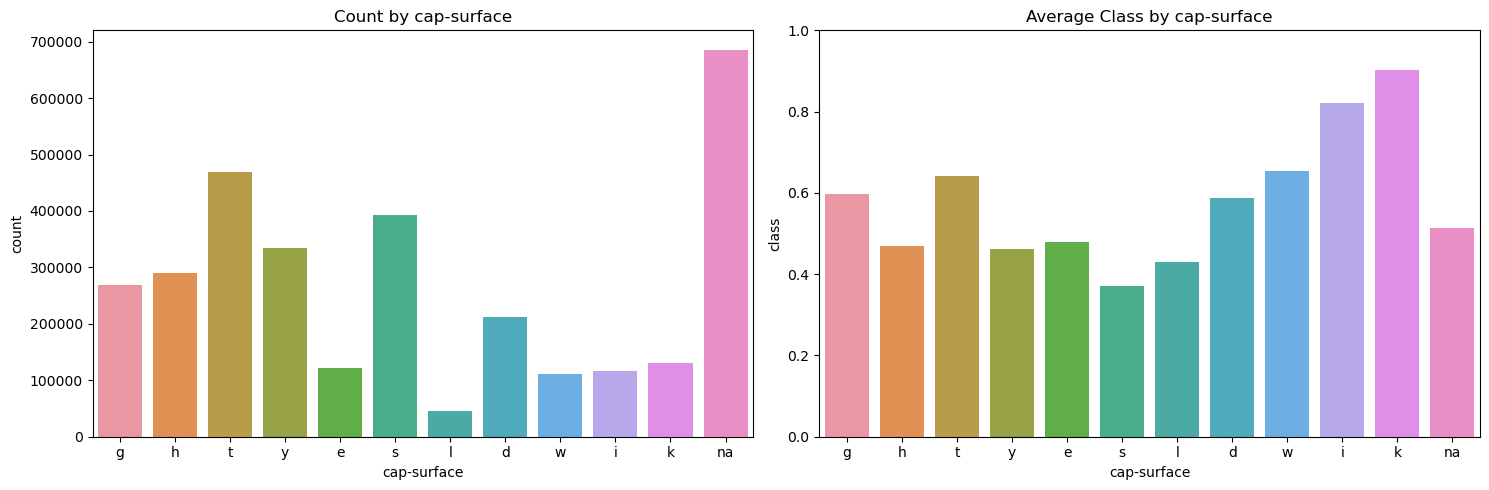

Feature Name: cap-color
----------------------------
             count     class
cap-color                   
n          1383745  0.490853
y           395168  0.622011
w           387091  0.497309
g           215137  0.413030
e           201325  0.793021
o           182500  0.717052
p            93541  0.690777
r            80015  0.906530
u            74881  0.541673
b            62543  0.127656
k            61167  0.598689
l            40386  0.488560
na             367  0.528610


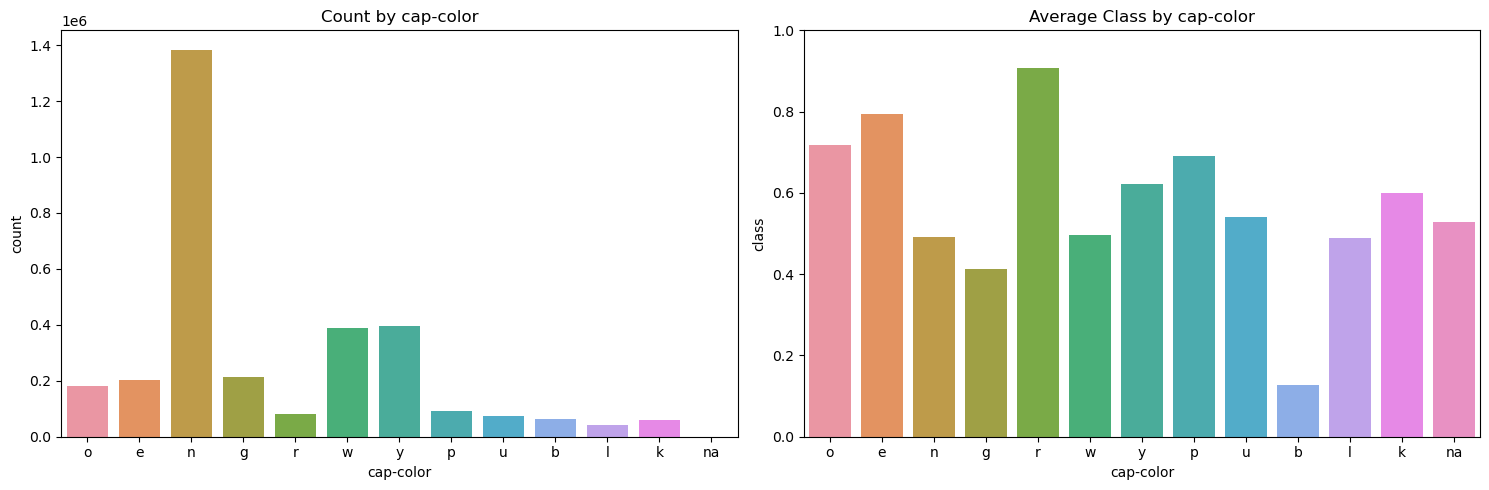

Feature Name: does-bruise-or-bleed
----------------------------
                        count     class
does-bruise-or-bleed                   
f                     2620074  0.555809
t                      557675  0.507130
na                        117  0.521368


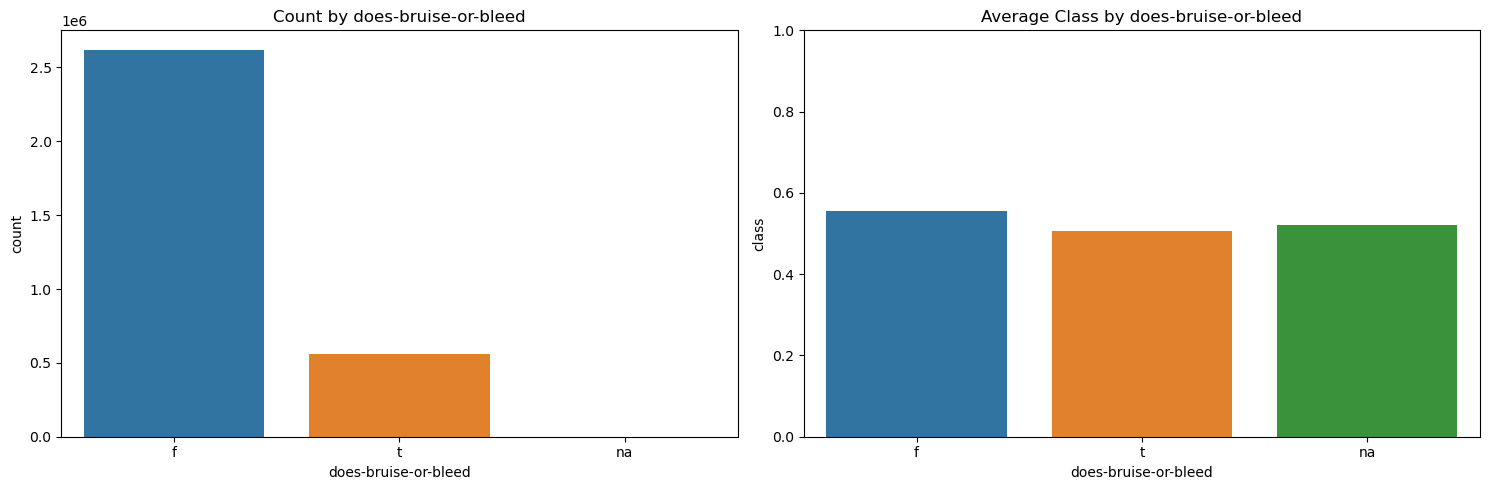

Feature Name: gill-attachment
----------------------------
                  count     class
gill-attachment                  
a                658730  0.645957
d                599483  0.571898
na               534291  0.638965
x                368291  0.539114
e                307506  0.349444
s                301087  0.588657
p                285111  0.290806
f                123367  0.512560


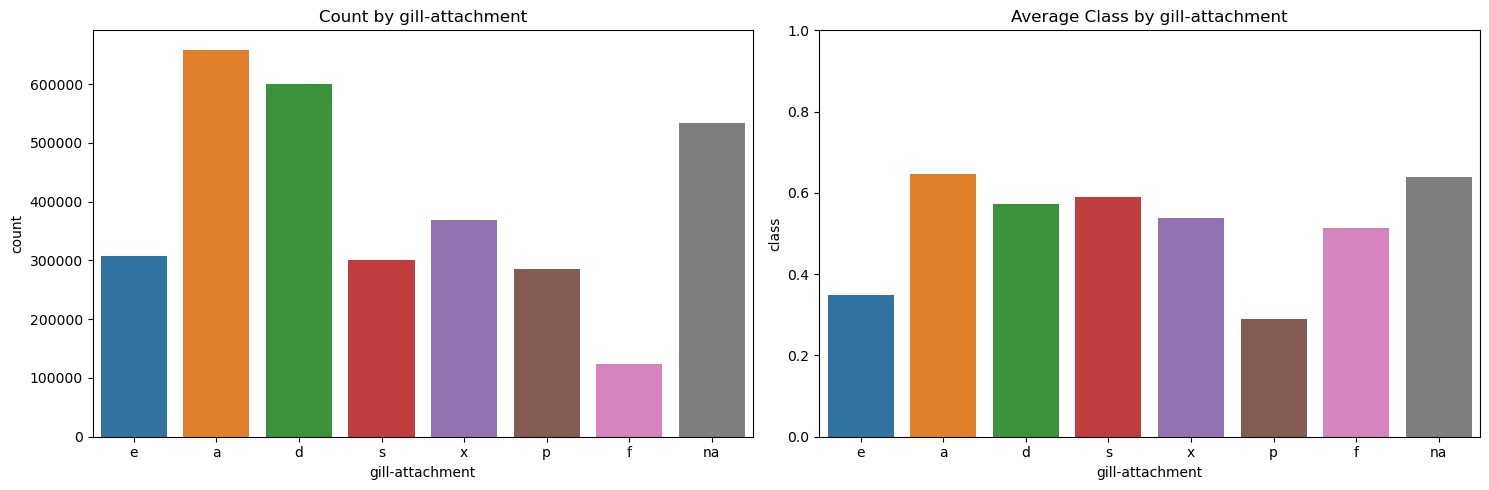

Feature Name: gill-spacing
----------------------------
                count     class
gill-spacing                   
c             1355736  0.572679
na            1283639  0.570693
d              415697  0.402372
f              122794  0.512289


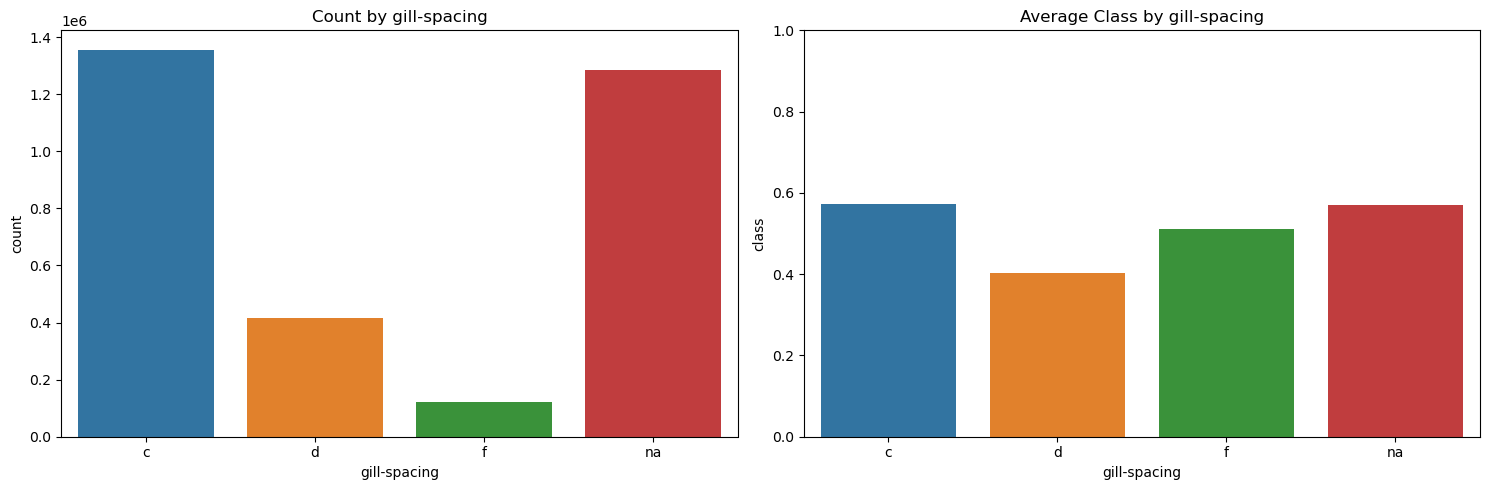

Feature Name: gill-color
----------------------------
             count     class
gill-color                  
w           950030  0.428926
n           553030  0.714457
y           479009  0.579227
p           349609  0.590171
g           216281  0.480819
o           160028  0.518509
k           130345  0.577958
f           123108  0.511998
r            64198  0.711876
e            57113  0.699298
b            48201  0.281197
u            46422  0.601762
na             492  0.571138


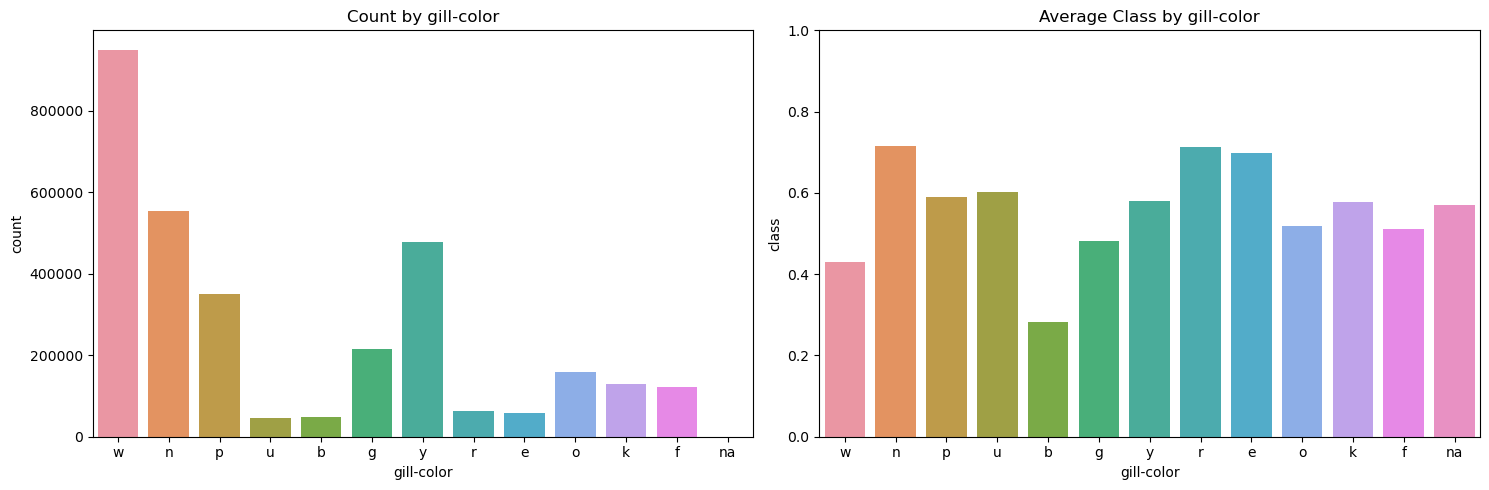

Feature Name: stem-root
----------------------------
             count     class
stem-root                   
na         2808740  0.539955
b           168978  0.351525
s           120123  0.694871
r            49215  0.995367
c            29298  0.996041
f             1512  0.995370


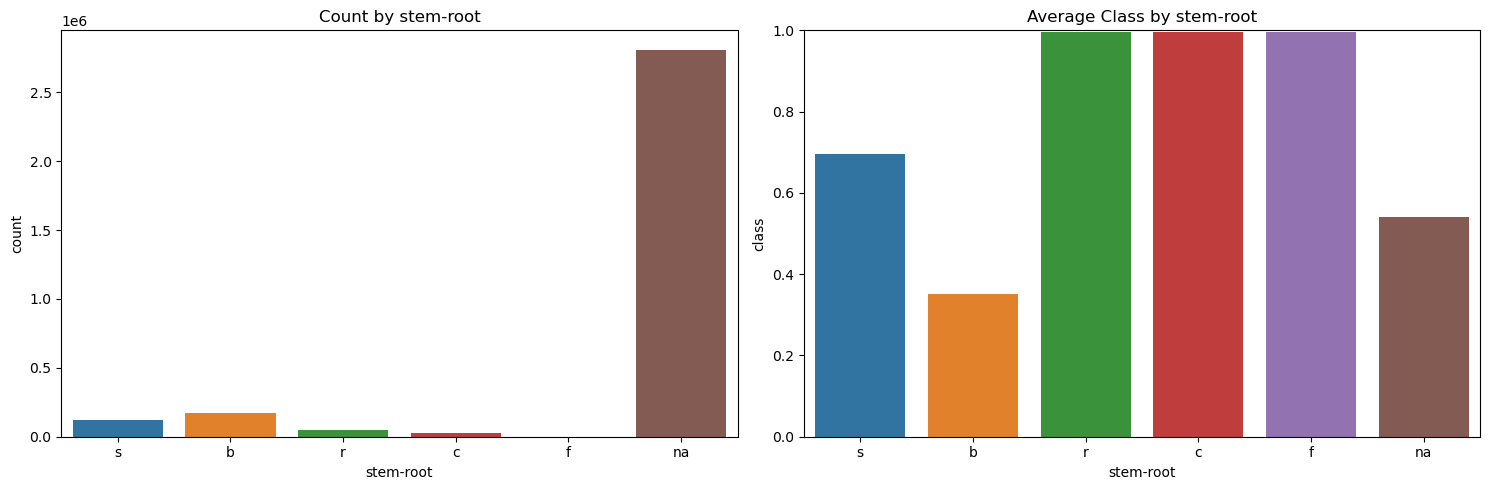

Feature Name: stem-surface
----------------------------
                count     class
stem-surface                   
na            2019379  0.512615
s              333633  0.395788
y              260440  0.700372
i              228742  0.638536
t              150618  0.541131
g               79845  0.996193
k               74964  0.697361
h               28818  0.996426
f                1427  0.996496


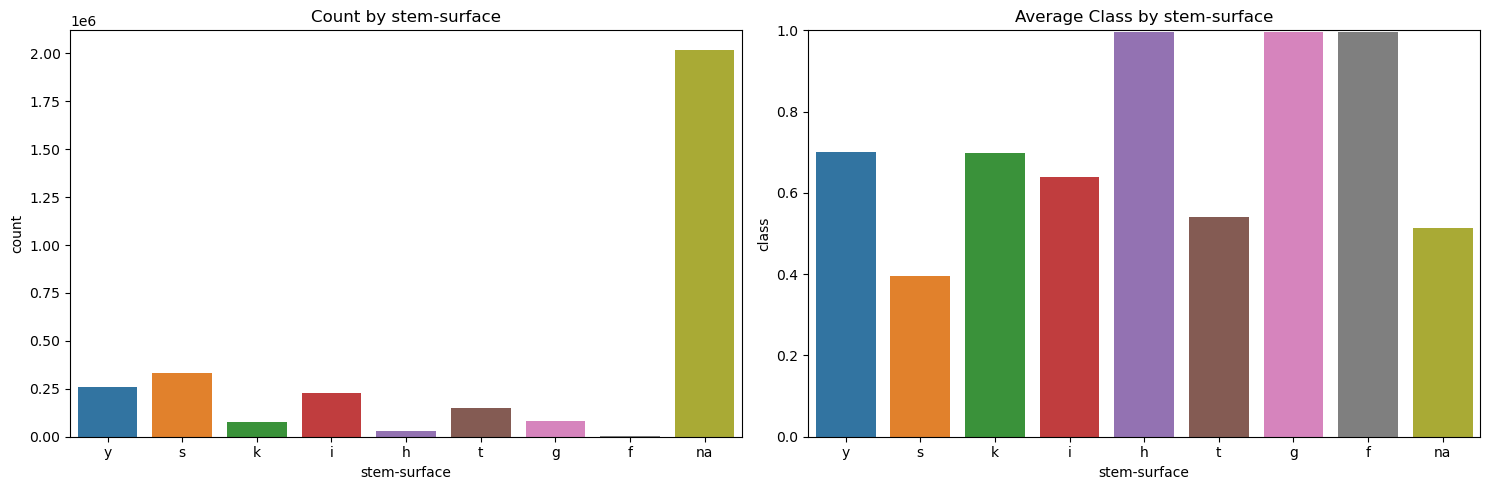

Feature Name: stem-color
----------------------------
              count     class
stem-color                   
w           1219563  0.417883
n           1021526  0.610653
y            381835  0.693551
g            134644  0.391447
o            113728  0.596871
e            105422  0.701998
u             68507  0.625819
p             55715  0.886081
k             34513  0.786486
r             22871  0.853789
l             10220  0.556360
b              7538  0.005439
f              1488  0.992608
na              296  0.581081


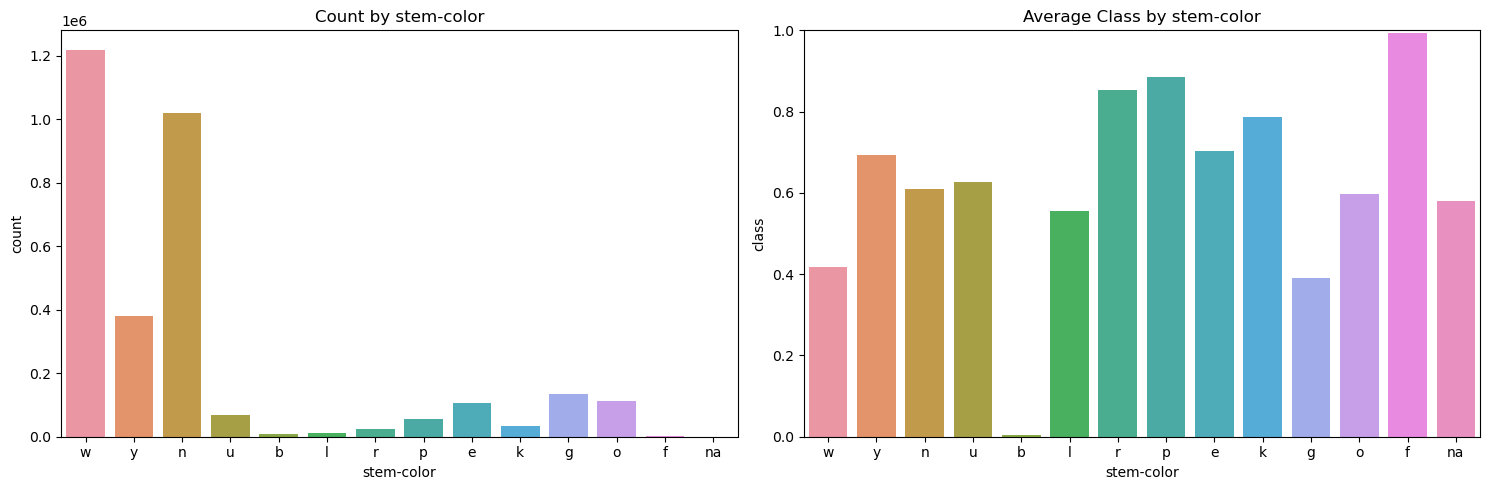

Feature Name: veil-type
----------------------------
             count     class
veil-type                   
na         3015316  0.541415
u           162550  0.655798


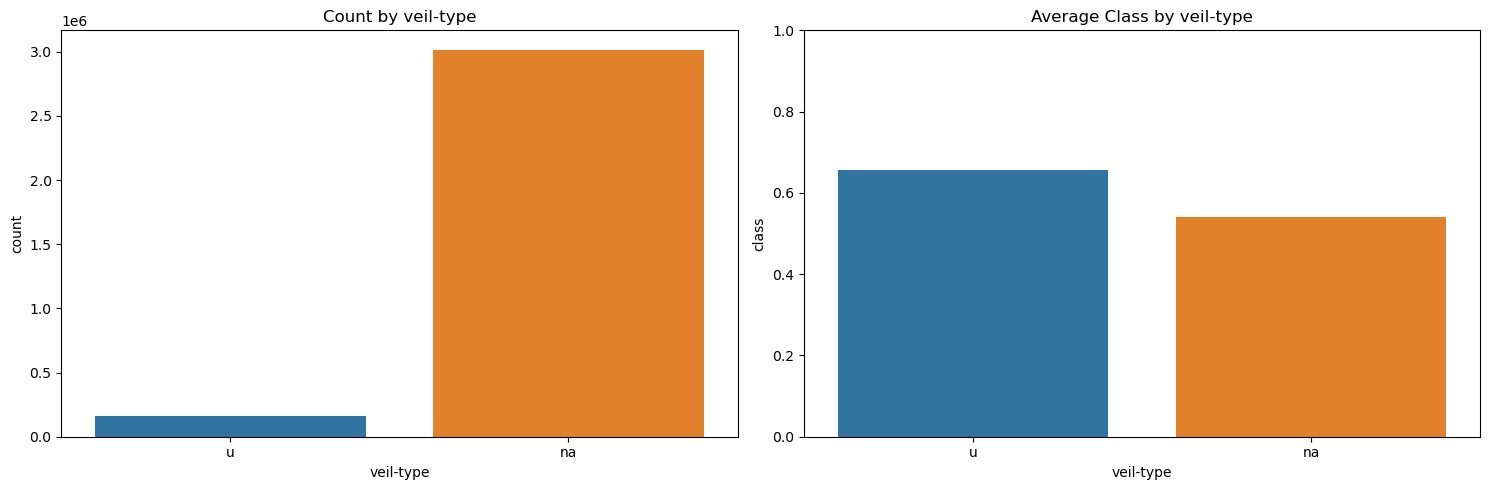

Feature Name: veil-color
----------------------------
              count     class
veil-color                   
na          2794596  0.546768
w            284544  0.504207
y             31000  0.005129
n             30564  0.996336
u             14379  0.994228
k             13433  0.999181
e              9350  0.999037


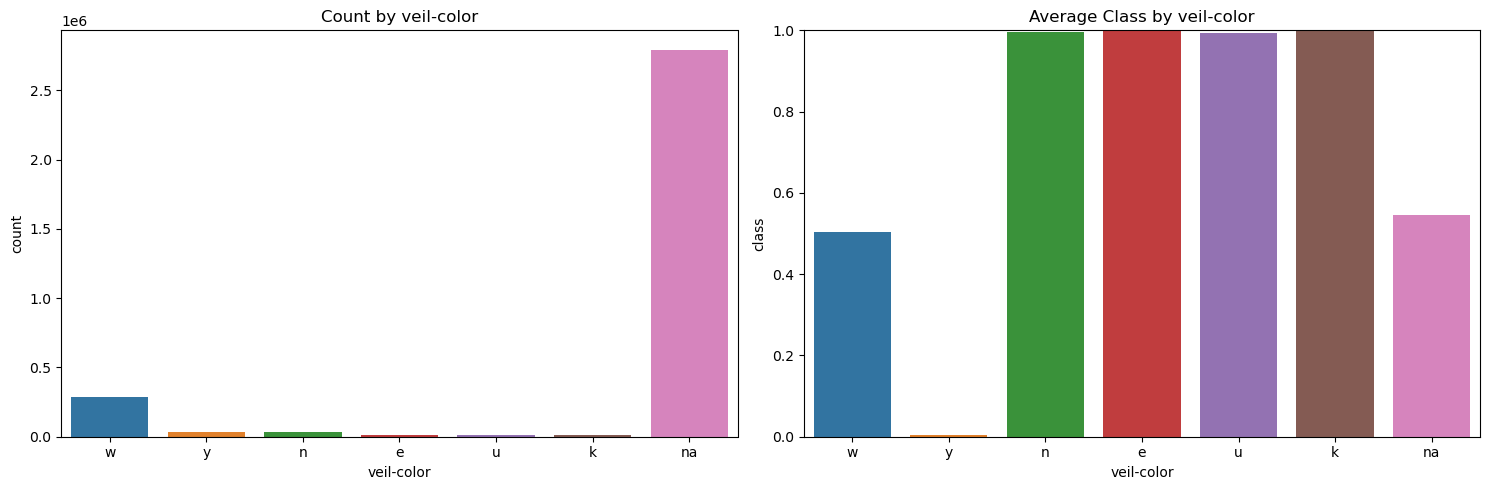

Feature Name: has-ring
----------------------------
            count     class
has-ring                   
f         2414574  0.533327
t          763149  0.591367
na            143  0.545455


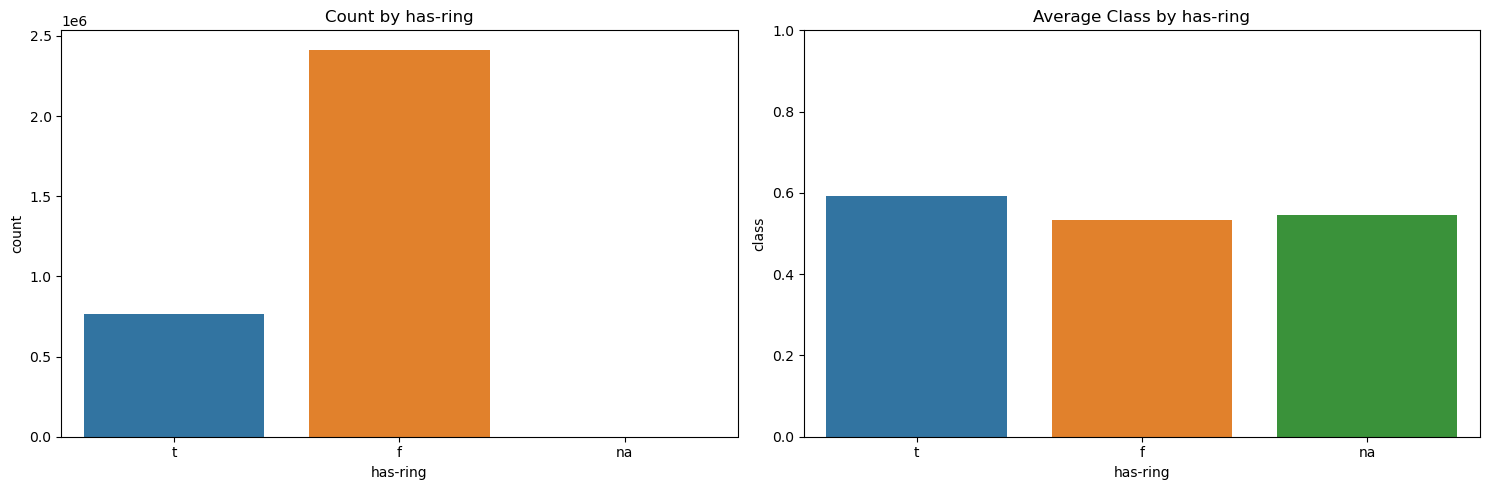

Feature Name: ring-type
----------------------------
             count     class
ring-type                   
f          2525383  0.546865
na          131751  0.396339
e           122441  0.579120
z           115898  0.996229
l            74870  0.387912
r            69308  0.397039
p            68943  0.515107
g            64927  0.421643
m             4345  0.012658


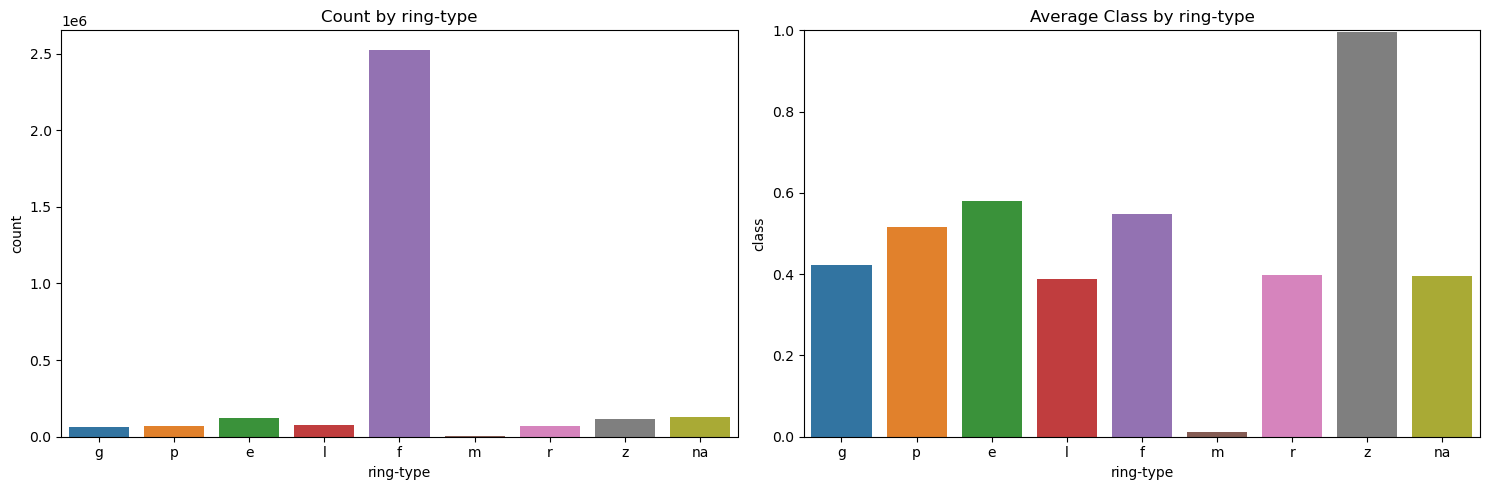

Feature Name: spore-print-color
----------------------------
                     count     class
spore-print-color                   
na                 2904452  0.529161
k                   109427  0.825518
p                    69496  0.712444
w                    51385  0.449781
n                    23677  0.997381
r                     8146  0.997299
u                     7438  0.997042
g                     3845  0.025748


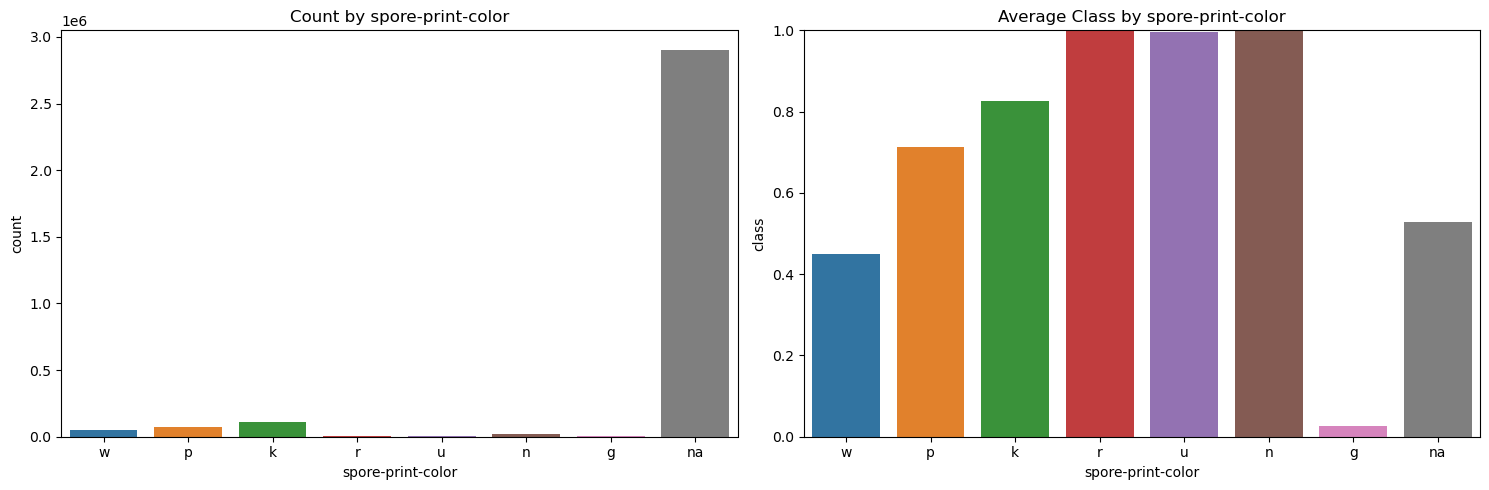

Feature Name: habitat
----------------------------
           count     class
habitat                   
d        2221635  0.529108
g         462850  0.674808
l         175060  0.394802
m         153889  0.537114
h         122138  0.668866
w          18883  0.004290
p          17540  0.996294
u           5379  0.007994
na           492  0.516260


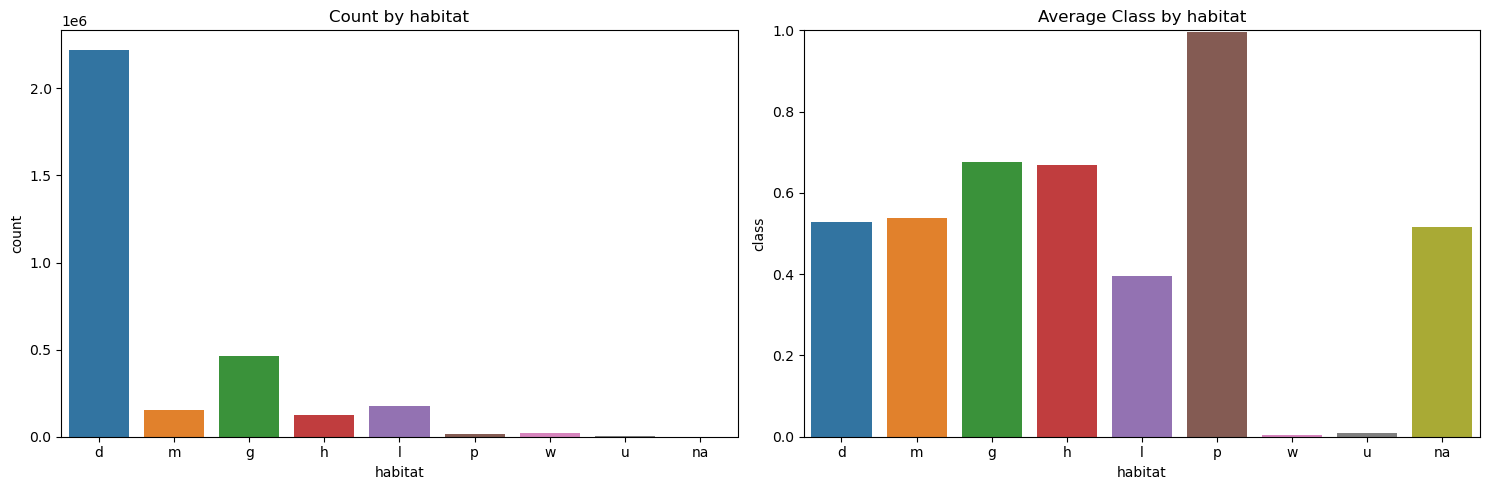

Feature Name: season
----------------------------
          count     class
season                   
a       1573461  0.571667
u       1176437  0.582370
w        283422  0.346808
s        144546  0.388977
na            0       NaN


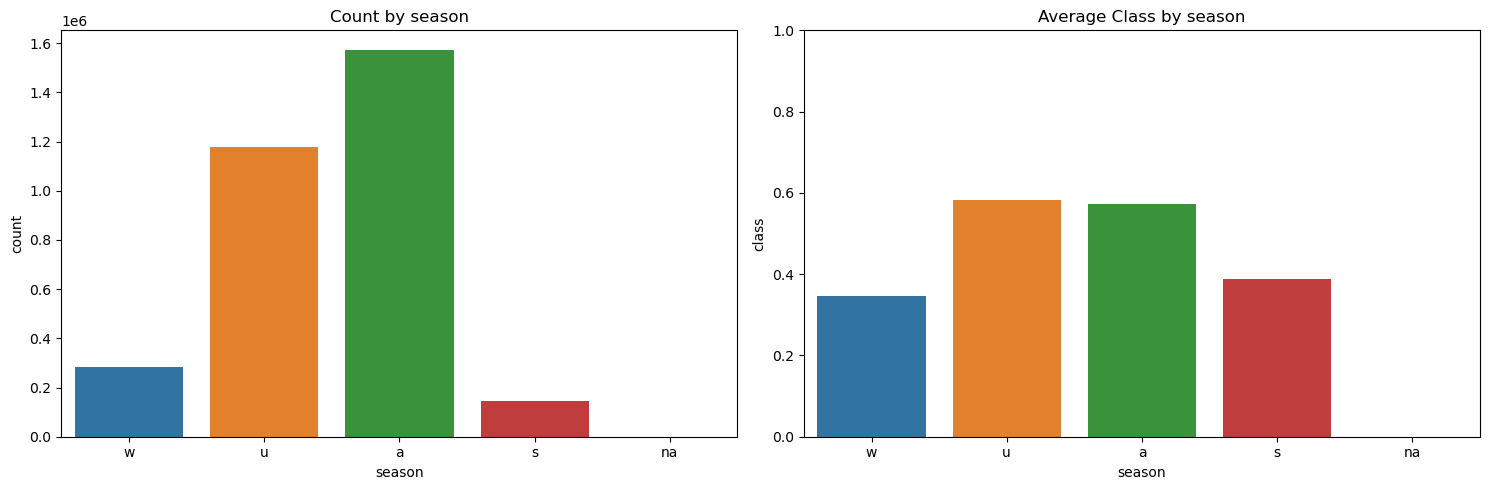

In [20]:
for feature in cat_features:

    print(f'Feature Name: {feature}')
    print('----------------------------')
    grouped = train_df.groupby(feature).agg({'season': 'count', 'class': 'mean'}).rename(columns = {'season': 'count'}).sort_values('count', ascending = False)

    print(grouped)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.barplot(x=grouped.index, y=grouped['count'], ax=axes[0])
    axes[0].set_title(f'Count by {feature}')

    sns.barplot(x=grouped.index, y=grouped['class'], ax=axes[1])
    axes[1].set_title(f"Average Class by {feature}")
    axes[1].set_ylim((0,1))

    plt.tight_layout()
    plt.show();

I will apply ordinal encoding to all categorical features.

In [21]:
# ordinal_encoding
train_ord = train_df.copy()
test_ord = test_df.copy()

for feature in cat_features:
    train_ord[feature] = train_ord[feature].cat.codes
    test_ord[feature] = test_ord[feature].cat.codes

## Numerical Features

In [22]:
num_features

['cap-diameter', 'stem-height', 'stem-width']

In [23]:
df_missing_values.loc[num_features, :]

train_n_missing_values  train_prop_missing_values  \
cap-diameter                       4                        0.0   
stem-height                        0                        0.0   
stem-width                         0                        0.0   

              test_n_missing_values  test_prop_missing_values  
cap-diameter                    7.0                       0.0  
stem-height                     1.0                       0.0  
stem-width                      0.0                       0.0

In [24]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

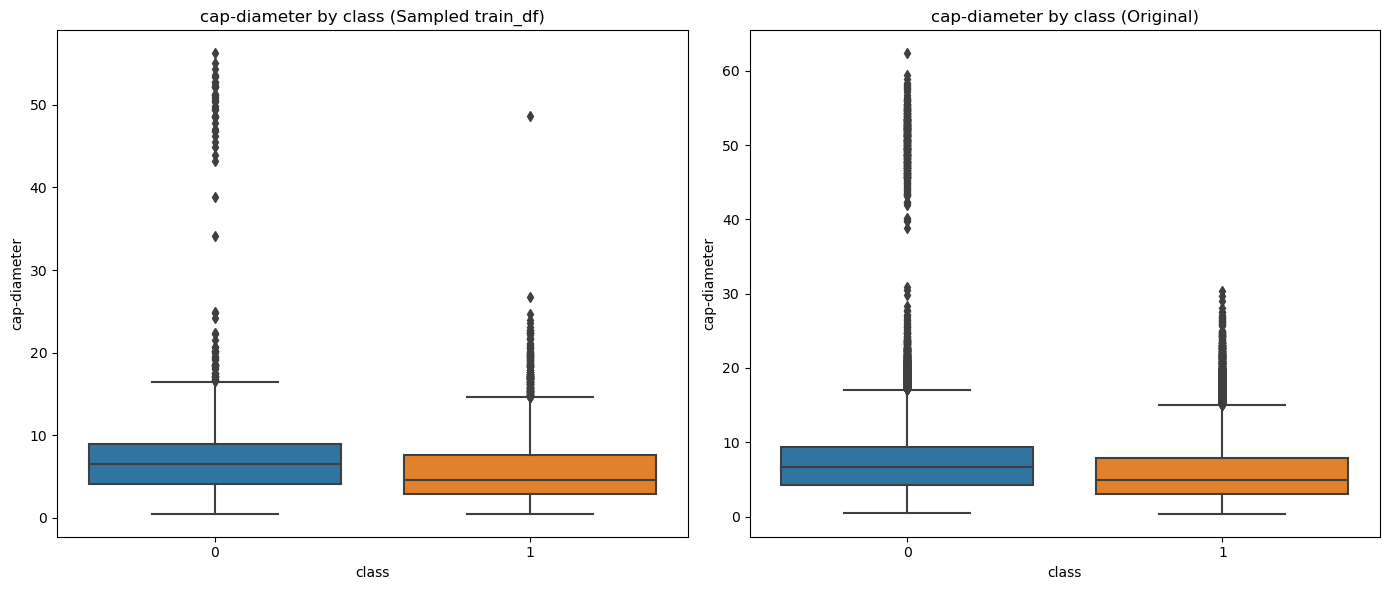

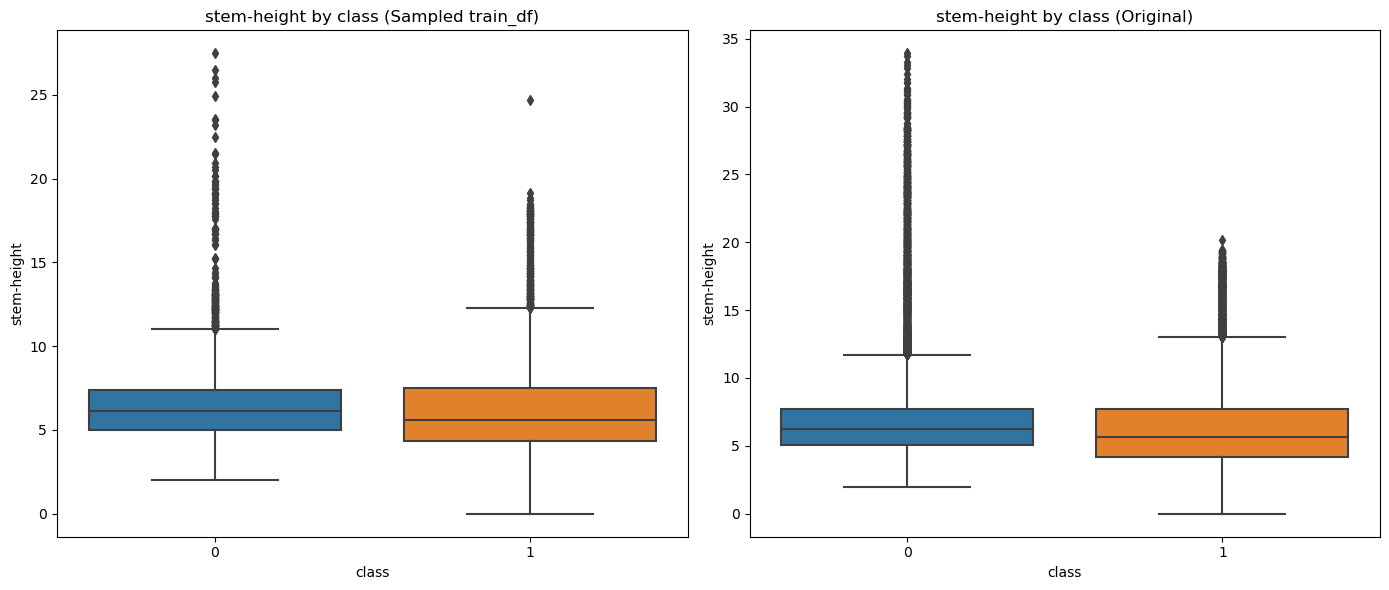

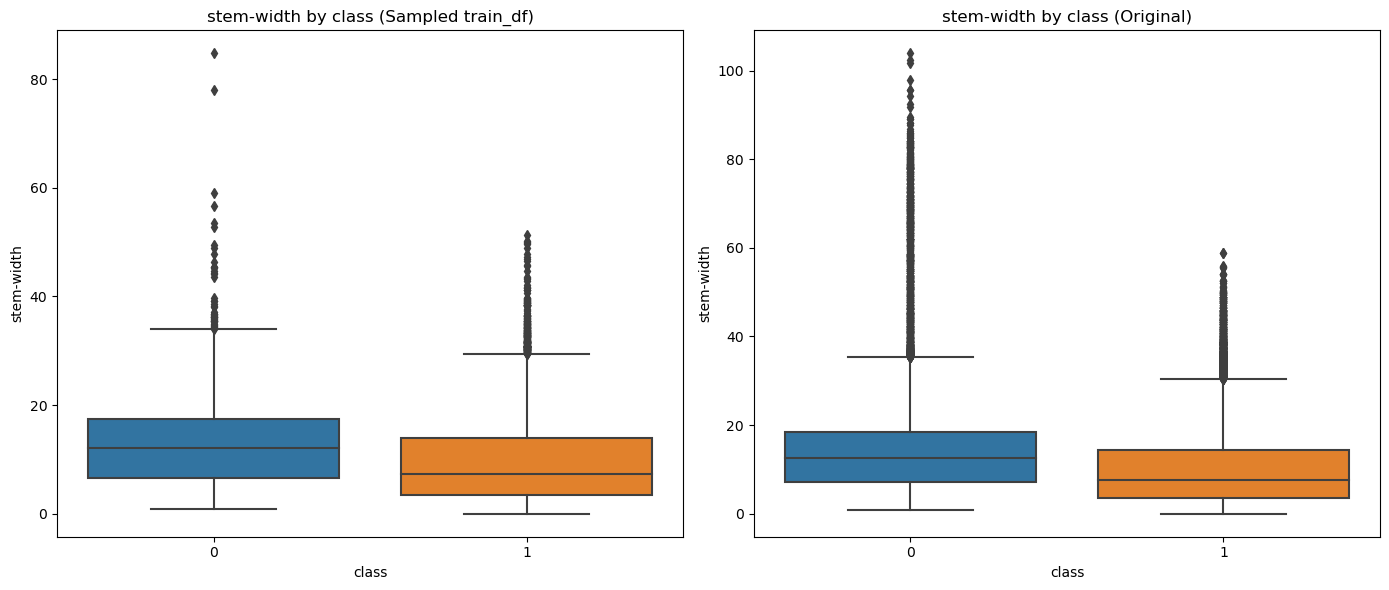

In [25]:
class_order = train_df['class'].unique()

for col in ['cap-diameter','stem-height','stem-width']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # train
    sns.boxplot(data=train_df.sample(10000), x='class', y=col, order=class_order, ax=axes[0])
    axes[0].set_title(f'{col} by class (Sampled train_df)')
    
    # original
    sns.boxplot(data=original_df, x='class', y=col, order=class_order, ax=axes[1])
    axes[1].set_title(f'{col} by class (Original)')

    plt.tight_layout()
    plt.show()

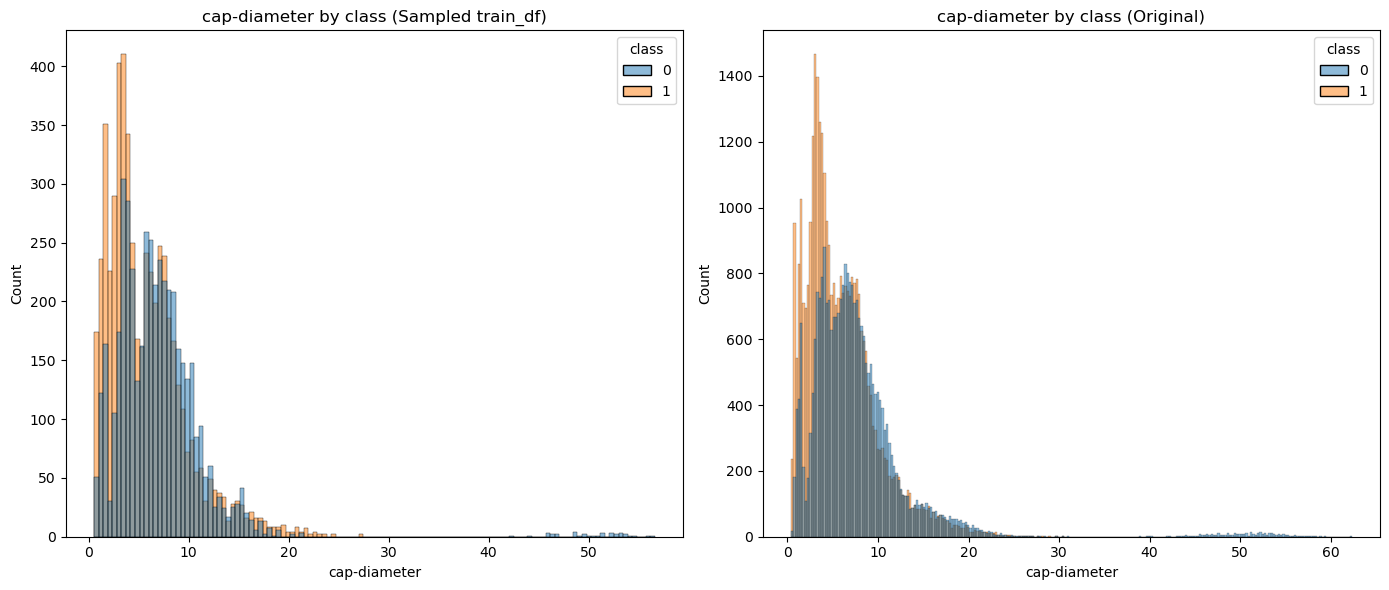

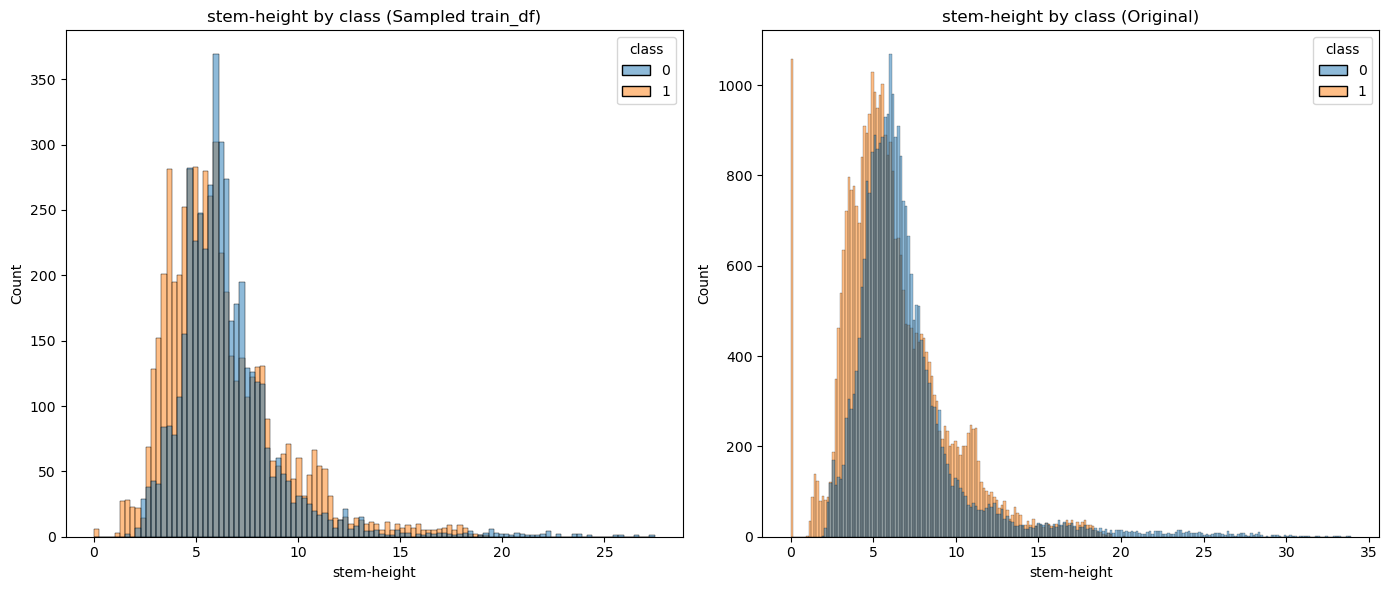

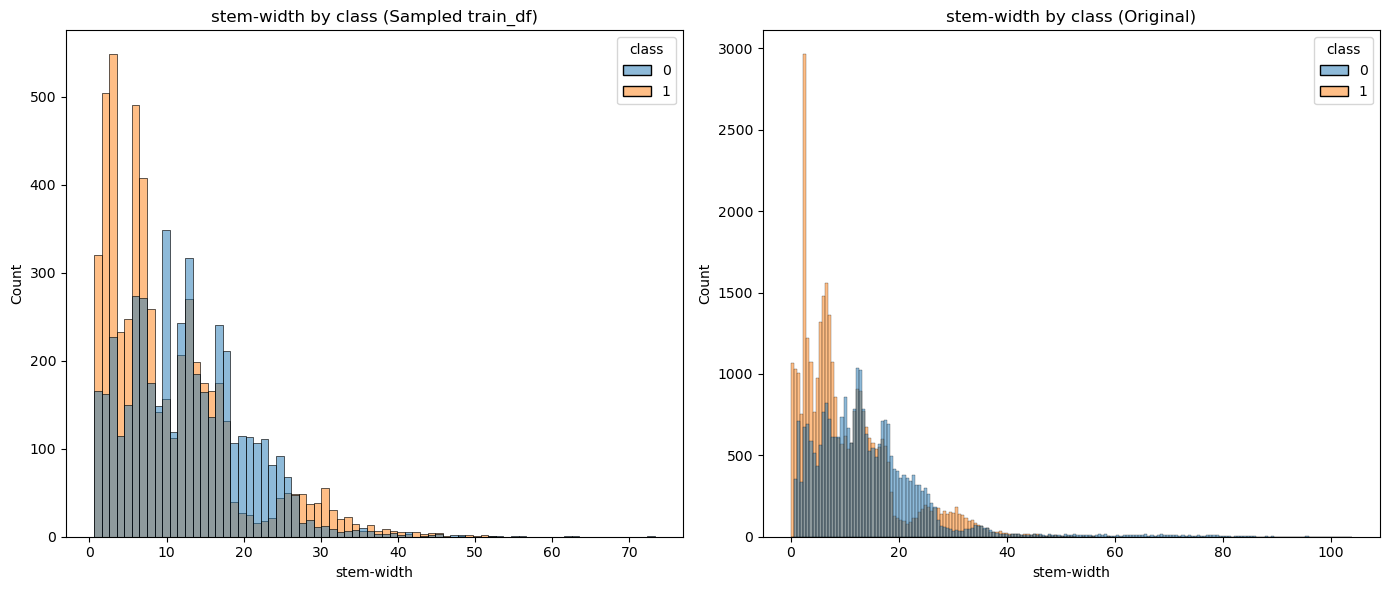

In [26]:
class_order = train_df['class'].unique()

for col in ['cap-diameter','stem-height','stem-width']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # train
    sns.histplot(data=train_df.sample(10000), x=col, hue = 'class', ax=axes[0])
    axes[0].set_title(f'{col} by class (Sampled train_df)')
    
    # original
    sns.histplot(data=original_df, x=col, hue = 'class', ax=axes[1])
    axes[1].set_title(f'{col} by class (Original)')

    plt.tight_layout()
    plt.show()

The sample distributions of the Kaggle dataset (combined with the original) resemble those of the original dataset. It is clear that these features are right-skewed. Most machine learning algorithms, especially those based on statistical methods like logistic regression and many others tend to perform better when the input features are normally distributed (or close to it). Applying some transformation (log, sqrt, power, etc.) might help.

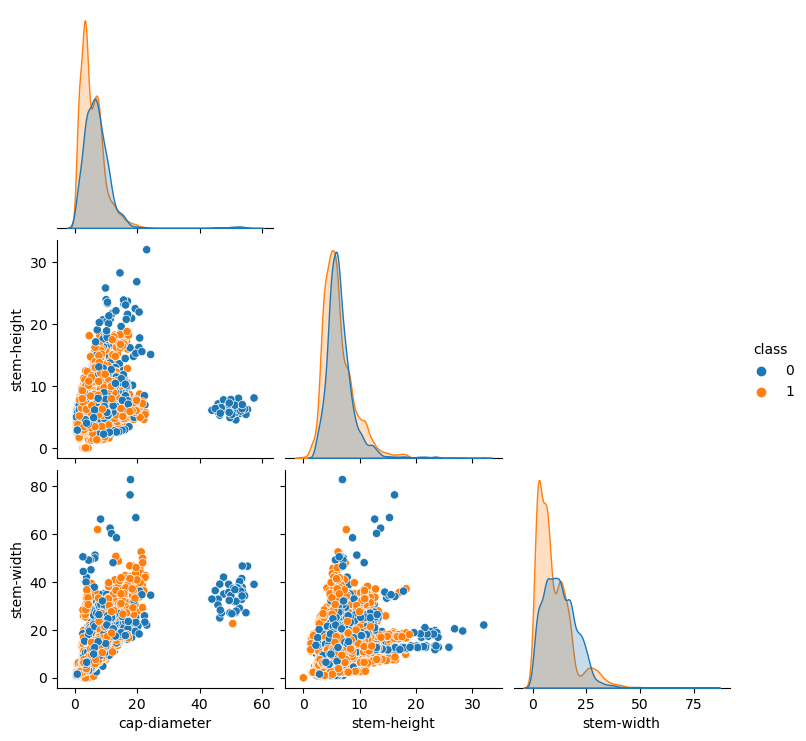

In [27]:
sns.pairplot(train_df[['cap-diameter','stem-height','stem-width', 'class']].sample(10000), hue = 'class', corner=True);

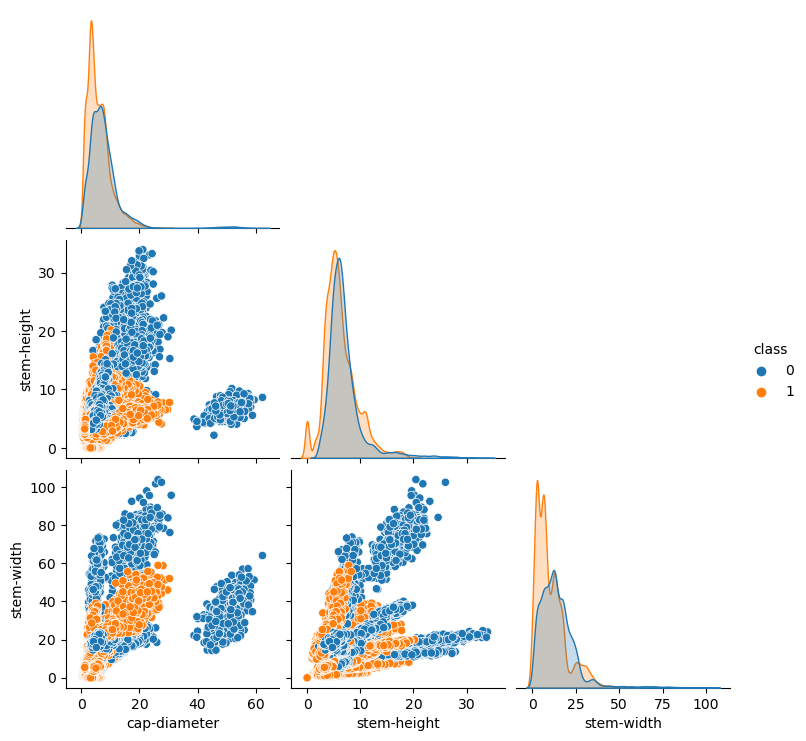

In [28]:
sns.pairplot(original_df, hue = 'class', corner=True);

In [29]:
print(f"Proportion of mushrooms with over 40 cm cap-diameter: {len(train_df.loc[train_df['cap-diameter']>40]['class']) / len(train_df)}")
print()
print(train_df.loc[train_df['cap-diameter']>40]['class'].value_counts())
print('--------------------------------------------------------------------')
print(train_df.loc[train_df['cap-diameter']>40]['class'].value_counts(normalize=True))

Proportion of mushrooms with over 40 cm cap-diameter: 0.004173240784853735

0    13025
1      237
Name: class, dtype: int64
--------------------------------------------------------------------
0    0.982129
1    0.017871
Name: class, dtype: float64


While this represents only 0.04% of the data, if ``cap-diameter`` exceeds 40 cm, it is almost guaranteed that the mushroom is edible.

In [30]:
train_df_sample = train_df[['stem-width', 'stem-height', 'cap-diameter', 'class']].sample(10000)
train_df_sample['class'] = train_df_sample['class']
std = StandardScaler()
train_df_sample_std = std.fit_transform(train_df_sample[['stem-width', 'stem-height', 'cap-diameter']])

fig = go.Figure(data=[go.Scatter3d(
    x=train_df_sample_std[:,0],
    y=train_df_sample_std[:,1],
    z=train_df_sample_std[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=train_df_sample['class'],            # Color by z value
        colorscale='Viridis', # Color scale
        opacity=0.8
    )
)])

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='stem-width',
    yaxis_title='stem-height',
    zaxis_title='cap-diameter'
))

# Show the plot
fig.show()

For mushrooms with less than 40 cm ``cap-diameter``, it seems that we need to take other features into consideration to distinguish poisonous and non-poisonous mushrooms.

# Feature Engineering

We have 3 numerical features (``cap-diameter``, ``stem-width``, ``stem-height``). Let's create new features using them and see if they have any predictive power.

In [31]:
train_df['cap-diameter-sqrt'] = np.sqrt(train_df['cap-diameter'])
train_df['stem-width-sqrt'] = np.sqrt(train_df['stem-width'])
train_df['stem-height-sqrt'] = np.sqrt(train_df['stem-height'])
train_df['cap-diameter-log'] = np.log(train_df['cap-diameter'])
train_df['stem-width-log'] = np.log(train_df['stem-width'])
train_df['stem-height-log'] = np.log(train_df['stem-height'])
train_df['cap_to_stem_height_ratio'] = train_df['cap-diameter'] / train_df['stem-height']
train_df['cap_to_stem_width_ratio'] = train_df['cap-diameter'] / train_df['stem-width']
train_df['stem_aspect_ratio'] = train_df['stem-height'] / train_df['stem-width']
train_df['cap_area'] = (train_df['cap-diameter'] / 2) ** 2 * 3.14159
train_df['stem_area'] = 2 * 3.14159 * (train_df['stem-width'] / 2) * train_df['stem-height']
train_df['stem_volume'] = 3.14159 * (train_df['stem-width'] / 2) ** 2 * train_df['stem-height']
train_df['cap_volume'] = (2 / 3) * 3.14159 * (train_df['cap-diameter'] / 2) ** 3
train_df['size_indicator'] = train_df['cap-diameter'] * train_df['stem-height'] * train_df['stem-width']

C:\Users\SeijiHi\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

C:\Users\SeijiHi\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



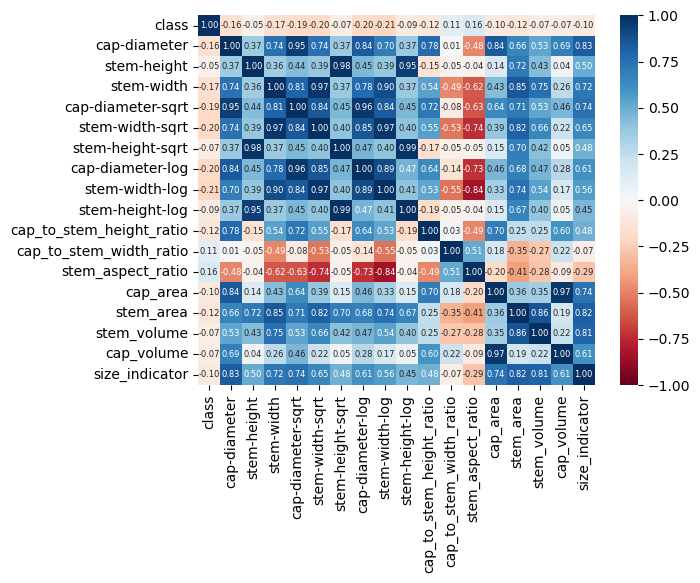

In [32]:
sns.heatmap(train_df.corr(numeric_only = True), 
            vmin = -1, 
            vmax = 1, 
            cmap = 'RdBu', 
            annot = True, 
            fmt = '.2f',
            annot_kws = {'fontsize': 6}
           );

In [33]:
train_df.corr(numeric_only = True)['class'][1:].sort_values(ascending = False)

stem_aspect_ratio           0.160323
cap_to_stem_width_ratio     0.108164
stem-height                -0.051304
stem-height-sqrt           -0.071664
cap_volume                 -0.072596
stem_volume                -0.073509
stem-height-log            -0.090679
cap_area                   -0.097845
size_indicator             -0.099170
cap_to_stem_height_ratio   -0.120612
stem_area                  -0.124156
cap-diameter               -0.162938
stem-width                 -0.170259
cap-diameter-sqrt          -0.188331
cap-diameter-log           -0.196751
stem-width-sqrt            -0.199794
stem-width-log             -0.210716
Name: class, dtype: float64

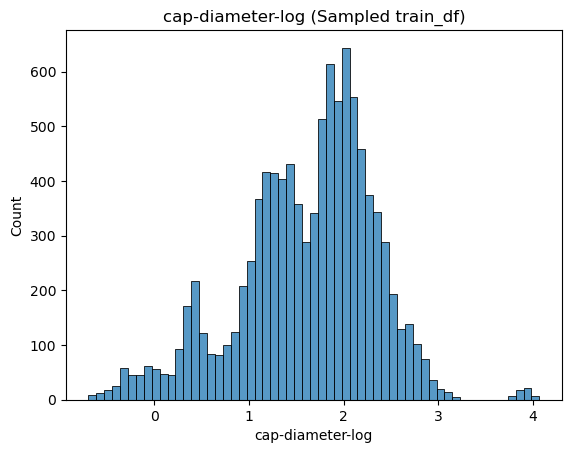

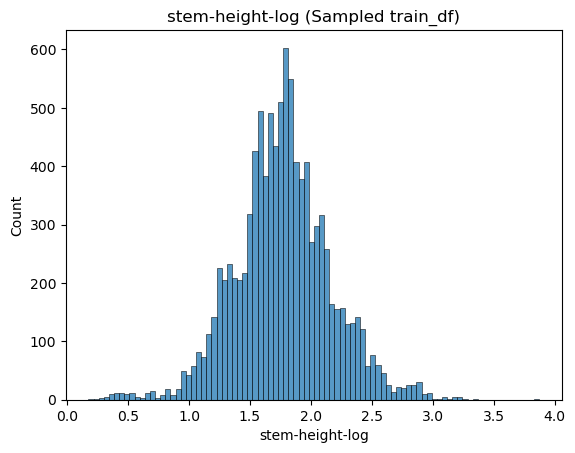

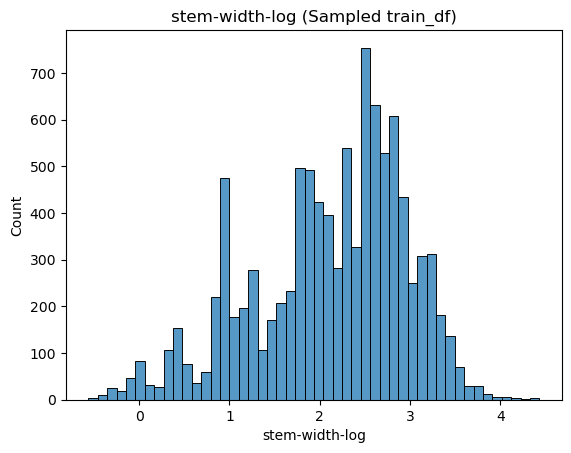

In [34]:
for col in ['cap-diameter-log','stem-height-log','stem-width-log']:
    sns.histplot(data=train_df.sample(10000), x=col)
    plt.title(f'{col} (Sampled train_df)')
    plt.show()

Log-tranformed features seem to work better than sqrt-transformed or non-transformed features. Additionaly, ``stem-aspect-ratio`` seems to have some predictive power.

# Preprocessing

In [35]:
X_train_ord = train_ord.drop(['class'], axis = 1)
y_train = train_ord['class']
X_test_ord = test_ord.copy()

### Imputing Missing Values

In [36]:
# impute missing values in numerical features
imputer = IterativeImputer(max_iter = 10, random_state = 42)

train_transformed_num_cols_ord = imputer.fit_transform(X_train_ord[['cap-diameter', 'stem-width', 'stem-height']])
test_transformed_num_cols_ord = imputer.transform(X_test_ord[['cap-diameter', 'stem-width', 'stem-height']])

X_train_ord[['cap-diameter', 'stem-width', 'stem-height']] = train_transformed_num_cols_ord
X_test_ord[['cap-diameter', 'stem-width', 'stem-height']] = test_transformed_num_cols_ord

### Adding New Features

In [37]:
# train
X_train_ord['cap-diameter-log'] = np.log1p(X_train_ord['cap-diameter'])
X_train_ord['stem-width-log'] = np.log1p(X_train_ord['stem-width'])
X_train_ord['stem-height-log'] = np.log1p(X_train_ord['stem-height'])

X_train_ord['stem_aspect_ratio'] = np.where((X_train_ord['stem-height'] == 0) | (X_train_ord['stem-width'] == 0), 
                                             0, 
                                             X_train_ord['stem-height'] / X_train_ord['stem-width']).astype('float32')

# test
X_test_ord['cap-diameter-log'] = np.log1p(X_test_ord['cap-diameter'])
X_test_ord['stem-width-log'] = np.log1p(X_test_ord['stem-width'])
X_test_ord['stem-height-log'] = np.log1p(X_test_ord['stem-height'])

X_test_ord['stem_aspect_ratio'] = np.where((X_test_ord['stem-height'] == 0) | (X_test_ord['stem-width'] == 0), 
                                            0, 
                                            X_test_ord['stem-height'] / X_test_ord['stem-width']).astype('float32')

In [38]:
drop_features = ['cap-diameter', 'stem-width', 'stem-height']

X_train_ord = X_train_ord.drop(drop_features, axis = 1)
X_test_ord = X_test_ord.drop(drop_features, axis = 1)

In [39]:
X_train_ord.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177866 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   cap-shape             3177866 non-null  int8   
 1   cap-surface           3177866 non-null  int8   
 2   cap-color             3177866 non-null  int8   
 3   does-bruise-or-bleed  3177866 non-null  int8   
 4   gill-attachment       3177866 non-null  int8   
 5   gill-spacing          3177866 non-null  int8   
 6   gill-color            3177866 non-null  int8   
 7   stem-root             3177866 non-null  int8   
 8   stem-surface          3177866 non-null  int8   
 9   stem-color            3177866 non-null  int8   
 10  veil-type             3177866 non-null  int8   
 11  veil-color            3177866 non-null  int8   
 12  has-ring              3177866 non-null  int8   
 13  ring-type             3177866 non-null  int8   
 14  spore-print-color     3177866 non-

In [40]:
X_test_ord.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   cap-shape             2077964 non-null  int8   
 1   cap-surface           2077964 non-null  int8   
 2   cap-color             2077964 non-null  int8   
 3   does-bruise-or-bleed  2077964 non-null  int8   
 4   gill-attachment       2077964 non-null  int8   
 5   gill-spacing          2077964 non-null  int8   
 6   gill-color            2077964 non-null  int8   
 7   stem-root             2077964 non-null  int8   
 8   stem-surface          2077964 non-null  int8   
 9   stem-color            2077964 non-null  int8   
 10  veil-type             2077964 non-null  int8   
 11  veil-color            2077964 non-null  int8   
 12  has-ring              2077964 non-null  int8   
 13  ring-type             2077964 non-null  int8   
 14  spore-print-color     2077964 non-

In [41]:
X_train_ord.describe().round(3).T

count   mean    std   min    25%    50%     75%  \
cap-shape             3177866.0  1.525  1.921  0.00  0.000  1.000   3.000   
cap-surface           3177866.0  5.422  3.893  0.00  2.000  5.000  10.000   
cap-color             3177866.0  3.505  2.493  0.00  2.000  2.000   5.000   
does-bruise-or-bleed  3177866.0  0.176  0.381  0.00  0.000  0.000   0.000   
gill-attachment       3177866.0  3.191  2.317  0.00  1.000  3.000   5.000   
gill-spacing          3177866.0  1.420  1.380  0.00  0.000  1.000   3.000   
gill-color            3177866.0  3.320  3.482  0.00  0.000  2.000   6.000   
stem-root             3177866.0  4.533  1.325  0.00  5.000  5.000   5.000   
stem-surface          3177866.0  5.879  3.035  0.00  3.000  8.000   8.000   
stem-color            3177866.0  2.207  3.102  0.00  0.000  1.000   2.000   
veil-type             3177866.0  0.949  0.220  0.00  1.000  1.000   1.000   
veil-color            3177866.0  5.353  1.803  0.00  6.000  6.000   6.000   
has-ring              3177866.0  0.760  0.427  0.00  1.000  1.000   1.000   
ring-type             3177866.0  4.073  1.332  0.00  4.000  4.000   4.000   
spore-print-color     3177866.0  6.550  1.527  0.00  7.000  7.000   7.000   
habitat               3177866.0  0.752  1.318  0.00  0.000  0.000   2.000   
season                3177866.0  1.497  0.721  0.00  1.000  2.000   2.000   
cap-diameter-log      3177866.0  1.835  0.560  0.03  1.463  1.910   2.225   
stem-width-log        3177866.0  2.265  0.719  0.00  1.788  2.366   2.812   
stem-height-log       3177866.0  1.937  0.335  0.00  1.735  1.929   2.129   
stem_aspect_ratio     3177866.0  0.983  0.920  0.00  0.415  0.652   1.178   

                         max  
cap-shape              7.000  
cap-surface           11.000  
cap-color             12.000  
does-bruise-or-bleed   2.000  
gill-attachment        7.000  
gill-spacing           3.000  
gill-color            12.000  
stem-root              5.000  
stem-surface           8.000  
stem-color            13.000  
veil-type              1.000  
veil-color             6.000  
has-ring               2.000  
ring-type              8.000  
spore-print-color      7.000  
habitat                8.000  
season                 3.000  
cap-diameter-log       4.403  
stem-width-log         4.653  
stem-height-log        4.497  
stem_aspect_ratio     11.870

# Feature Importance

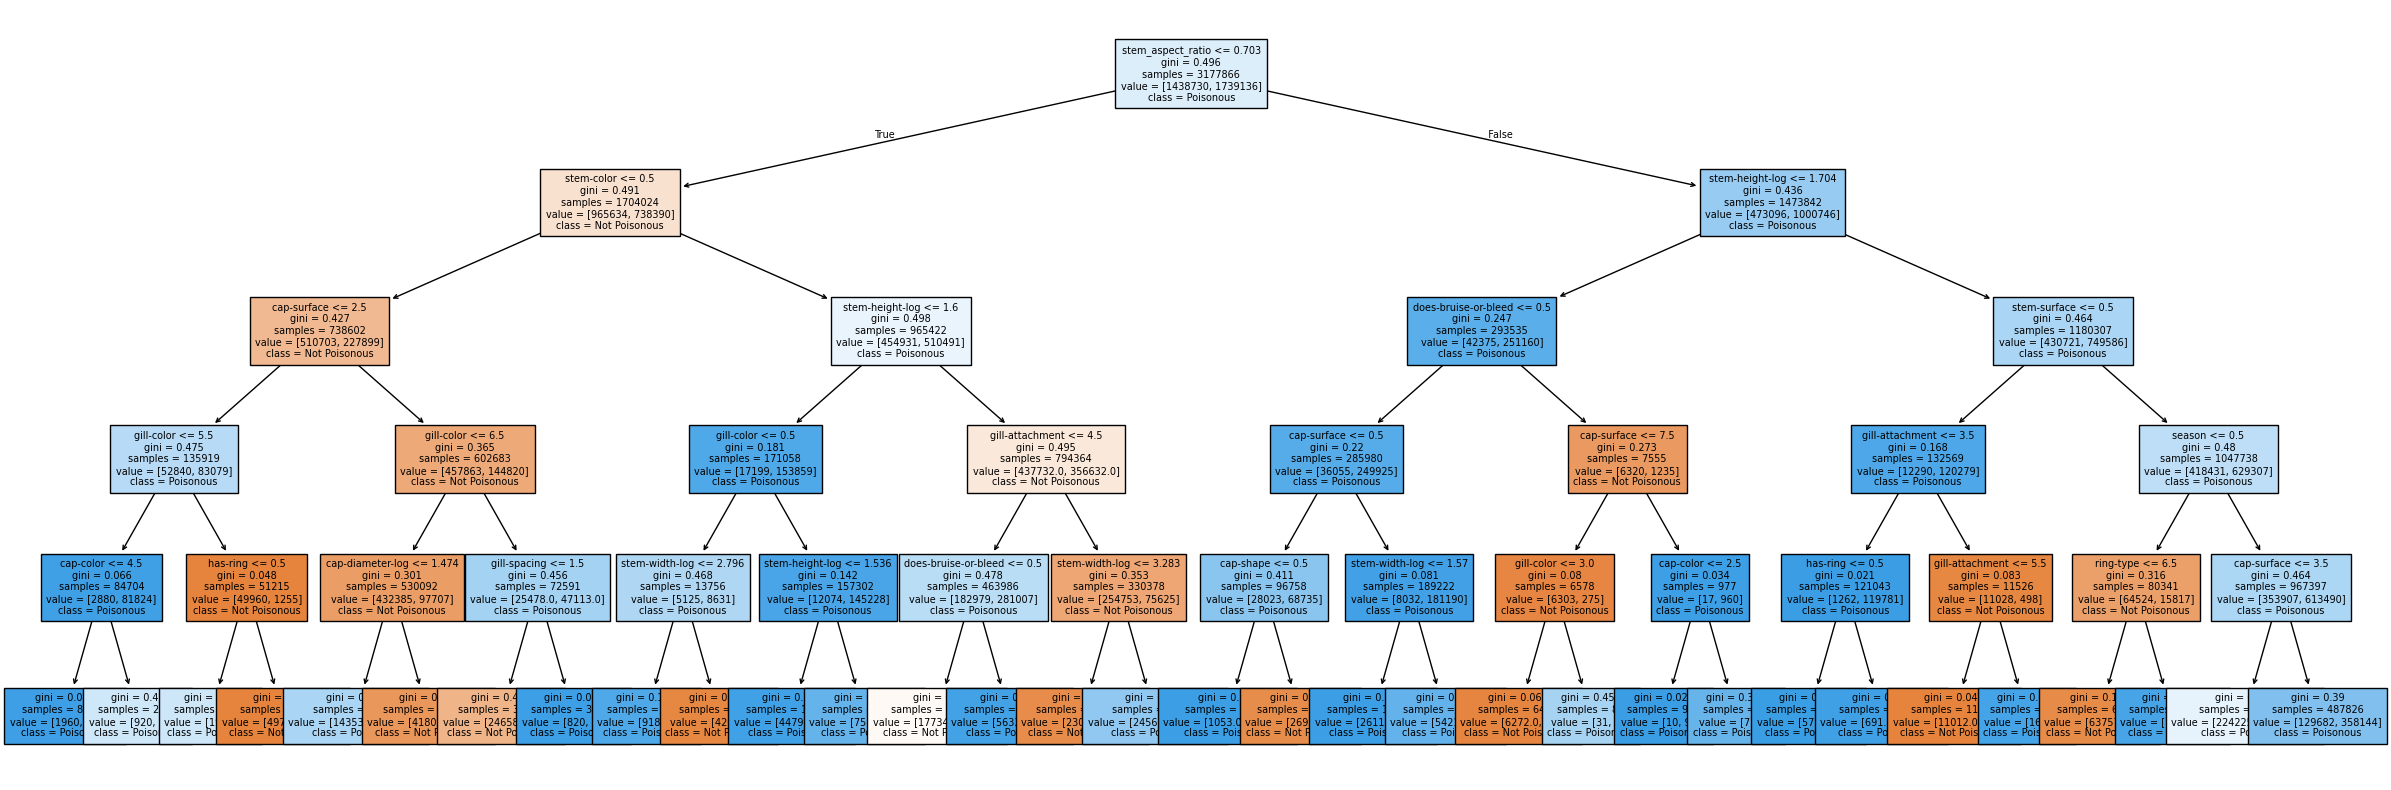

In [42]:
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train_ord, y_train)

plt.figure(figsize=(30, 10))
plot_tree(dt, 
          feature_names=X_train_ord.columns, 
          class_names = ['Not Poisonous', 'Poisonous'], 
          fontsize=7, 
          impurity=True, 
          filled=True)

plt.show()

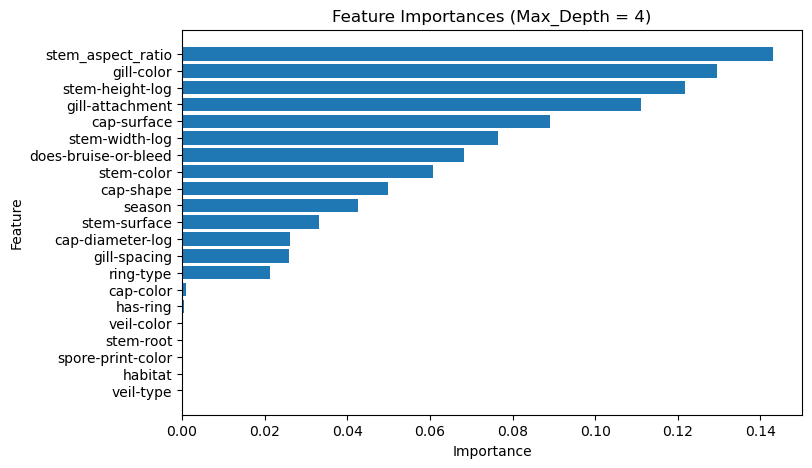

In [43]:
importances = dt.feature_importances_
feature_names = X_train_ord.columns

indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.title("Feature Importances (Max_Depth = 4)")
plt.barh(range(X_train_ord.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train_ord.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Modeling

In [44]:
# def beautified_confusion_matrix(confusion_matrix, model_name):
#     sns.heatmap(
#         confusion_matrix,
#         cmap = 'Blues',
#         annot = True,
#         fmt = 'g',
#         square = True,
#         xticklabels = ["Not Poisonous", "Poisonous"],
#         yticklabels = ["Not Poisonous", "Poisonous"]
#     ).set(
#         xlabel = 'Prediction',
#         ylabel = 'Actual',
#         title = f'{model_name} Confusino Matrix'
#     )

In [45]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [46]:
skf = StratifiedKFold(n_splits=10)

In [47]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_ord, y_train, test_size=0.05, shuffle=True, stratify=y_train, random_state=42)

### XGB

In [48]:
# xgb = XGBClassifier(random_state = 42)

# score_train_xgb = cross_val_score(xgb, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
# score_train_mean_xgb = score_train_xgb.mean().round(5)
# # y_pred = cross_val_predict(xgb, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

# print(f'Train Score: {score_train_xgb}')
# print(f'Mean Train MCC: {score_train_mean_xgb}')

# # Mean Train MCC: 0.98292

#### Hyperparameter Tuning

In [49]:
# def objective(trial):
#     # Suggest values for hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 40)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log = True)
#     subsample = trial.suggest_float('subsample', 0.7, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#     reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True)
#     reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True)
#     gamma = trial.suggest_float('gamma', 0, 1.0)
#     min_child_weight = trial.suggest_float('min_child_weight', 0.01, 10, log = True)
#     max_leaves = trial.suggest_int('max_leaves', 0, 255)
#     grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
#     # Initialize the XGBClassifier with the suggested parameters
#     model = XGBClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         reg_alpha = reg_alpha,
#         reg_lambda = reg_lambda,
#         gamma=gamma,
#         min_child_weight = min_child_weight,
#         max_leaves = max_leaves,
#         grow_policy = grow_policy,
#         enable_categorical = True,
#         tree_method = 'hist'        
#     )
    
#     # Train the model
#     model.fit(X_tr, y_tr)
    
#     # Make predictions
#     y_pred = model.predict(X_val)
    
#     # Calculate accuracy
#     mcc = matthews_corrcoef(y_val, y_pred)
    
#     return mcc

In [50]:
# # Create an Optuna study
# study_name = "xgb"
# study = optuna.create_study(direction='maximize', study_name = study_name)

# # Optimize the study
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters and best score
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [51]:
xgb_best_params = {'n_estimators': 453, 
                   'max_depth': 36, 
                   'learning_rate': 0.06109541510489739, 
                   'subsample': 0.7293940112631923, 
                   'colsample_bytree': 0.522393214128453, 
                   'reg_alpha': 1.1517036920323964, 
                   'reg_lambda': 6.300424569323979, 
                   'gamma': 0.5448447688013656, 
                   'min_child_weight': 0.3189111738010099, 
                   'max_leaves': 255, 
                   'grow_policy': 'lossguide',
                   'enable_categorical': True,
                   'tree_method': 'hist'
                  }

In [52]:
xgb = XGBClassifier(**xgb_best_params, random_state = 42)

score_train_xgb = cross_val_score(xgb, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
score_train_mean_xgb = score_train_xgb.mean().round(5)
# y_pred = cross_val_predict(xgb, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_xgb}')
print(f'Mean Train MCC: {score_train_mean_xgb}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 10.4min remaining: 24.3min


Train Score: [0.9849  0.98413 0.9846  0.98427 0.98474 0.98453 0.98417 0.98466 0.98496
 0.98779]
Mean Train MCC: 0.98488


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.4min finished


In [53]:
xgb = XGBClassifier(**xgb_best_params, random_state = 42)

xgb.fit(X_train_ord, y_train)

y_pred = xgb.predict(X_test_ord)

y_pred = np.where(y_pred == 1, 'p', 'e')

# Leaderboard Score: 0.98489

### LGBM

In [54]:
# lgbm = lgb.LGBMClassifier(random_state = 42)

# score_train_lgbm = cross_val_score(lgbm, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
# score_train_mean_lgbm = score_train_lgbm.mean().round(5)
# # y_pred = cross_val_predict(lgbm, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

# print(f'Train Score: {score_train_lgbm}')
# print(f'Mean Train MCC: {score_train_mean_lgbm}')

# # Mean Train MCC: 0.97877

#### Hyperparameter Tuning

In [55]:
# def objective(trial):
#     # Suggest values for hyperparameters
#     num_leaves = trial.suggest_int('num_leaves', 31, 512)
#     max_depth = trial.suggest_int('max_depth', -1, 50)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True)
#     min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
#     subsample = trial.suggest_float('subsample', 0.5, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#     reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
#     reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    
#     # Define the model with the suggested hyperparameters
#     model = lgb.LGBMClassifier(
#         num_leaves=num_leaves,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         n_estimators=n_estimators,
#         min_child_weight=min_child_weight,
#         min_child_samples = min_child_samples,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda
#     )
#     # Train the model
#     model.fit(X_tr, y_tr)
    
#     # Make predictions
#     y_pred = model.predict(X_val)
    
#     # Calculate accuracy
#     mcc = matthews_corrcoef(y_val, y_pred)
    
#     return mcc

In [56]:
# # Create an Optuna study
# study_name = "lgbm"
# study = optuna.create_study(direction='maximize', study_name = study_name)

# # Optimize the study
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters and best score
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [57]:
lgbm_best_params = {'num_leaves': 486, 
                    'max_depth': 23, 
                    'learning_rate': 0.02973204643136443, 
                    'n_estimators': 818, 
                    'min_child_weight': 0.06402590152470944, 
                    'min_child_samples': 71, 
                    'subsample': 0.6163590582610122, 
                    'colsample_bytree': 0.535819999608087, 
                    'reg_alpha': 4.595337196681044e-07, 
                    'reg_lambda': 0.8312427842549337
                  }

In [58]:
lgbm = lgb.LGBMClassifier(**lgbm_best_params, random_state = 42)

score_train_lgbm = cross_val_score(lgbm, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
score_train_mean_lgbm = score_train_lgbm.mean().round(5)
# y_pred = cross_val_predict(lgbm, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_lgbm}')
print(f'Mean Train MCC: {score_train_mean_lgbm}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 17.9min remaining: 41.8min


Train Score: [0.9849  0.98424 0.98478 0.98441 0.98486 0.9845  0.9843  0.98466 0.98497
 0.98764]
Mean Train MCC: 0.98493


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 18.5min finished


In [59]:
lgbm.fit(X_train_ord, y_train)

y_pred = lgbm.predict(X_test_ord)

y_pred = np.where(y_pred == 1, 'p', 'e')

# Leaderboard Score: 0.98490

[LightGBM] [Info] Number of positive: 1739136, number of negative: 1438730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 3177866, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547265 -> initscore=0.189628
[LightGBM] [Info] Start training from score 0.189628


## Neural Network

In [60]:
# mlp = MLPClassifier(hidden_layer_sizes=(50, 50),
#                     activation='relu', 
#                     solver='adam', 
#                     batch_size=256, 
#                     max_iter=100, 
#                     early_stopping=True, 
#                     validation_fraction=0.1, 
#                     n_iter_no_change=3, 
#                     random_state=42)

In [61]:
# score_train_mlp = cross_val_score(mlp, X_train_ord_no_outliers, y_train_no_outliers, cv=10, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
# score_train_mean_mlp = score_train_mlp.mean().round(5)
# # y_pred = cross_val_predict(mlp, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

# print(f'Train Score: {score_train_mlp}')
# print(f'Mean Train MCC: {score_train_mean_mlp}')

# # Mean Train MCC: 0.97927

#### Hyperparameter Tuning

In [62]:
# def objective(trial):
#     # Suggest hyperparameters
#     hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50), (100, 100), (50, 50, 50), (100, 50, 50), (100, 100, 50), (100, 100, 100)])
#     activation = trial.suggest_categorical('activation', ['tanh', 'relu'])
#     alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
#     learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
#     max_iter = trial.suggest_int('max_iter', 100, 1000)
#     tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512, 1024, 2048])
#     early_stopping = trial.suggest_categorical('early_stopping', [True, False])
#     n_iter_no_change = trial.suggest_int('n_iter_no_change', 5, 20)

#     # Define the model with the suggested hyperparameters
#     model = MLPClassifier(
#         hidden_layer_sizes=hidden_layer_sizes,
#         activation=activation,
#         alpha=alpha,
#         learning_rate_init=learning_rate_init,
#         max_iter=max_iter,
#         tol=tol,
#         batch_size=batch_size,
#         early_stopping=early_stopping,
#         n_iter_no_change=n_iter_no_change,
#         solver = 'adam'
#     )
#     # Train the model
#     model.fit(X_tr, y_tr)
    
#     # Make predictions
#     y_pred = model.predict(X_val)
    
#     # Calculate accuracy
#     mcc = matthews_corrcoef(y_val, y_pred)
    
#     return mcc

In [63]:
# # Create an Optuna study
# study_name = "mlp"
# study = optuna.create_study(direction='maximize', study_name = study_name)

# # Optimize the study
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters and best score
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [64]:
mlp_best_params = {'hidden_layer_sizes': (100, 100, 100), 
                   'activation': 'tanh', 
                   'alpha': 0.0015428196364976568, 
                   'learning_rate_init': 0.0005197690235846296, 
                   'max_iter': 110, 
                   'tol': 4.0969845149937e-05, 
                   'batch_size': 256, 
                   'early_stopping': False, 
                   'n_iter_no_change': 19
                  }

In [65]:
mlp = MLPClassifier(**mlp_best_params, 
                    solver='adam',  
                    validation_fraction=0.1, 
                    random_state=42)

score_train_mlp = cross_val_score(mlp, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
score_train_mean_mlp = score_train_mlp.mean().round(5)
# y_pred = cross_val_predict(mlp, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_mlp}')
print(f'Mean Train MCC: {score_train_mean_mlp}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 36.3min remaining: 84.8min


Train Score: [0.98304 0.98209 0.98278 0.98241 0.98282 0.9825  0.98202 0.98277 0.98311
 0.98641]
Mean Train MCC: 0.983


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 43.8min finished


In [66]:
mlp.fit(X_train_ord, y_train)

y_pred = mlp.predict(X_test_ord)

y_pred = np.where(y_pred == 1, 'p', 'e')

# Leaderboard Score: 0.98275

## Voting
### Soft Voting

In [67]:
# lgbm = lgb.LGBMClassifier(**lgbm_best_params, random_state = 42)
# xgb = XGBClassifier(**xgb_best_params, random_state = 42)

# soft_vt = VotingClassifier(
#     estimators = [
#         ('lgb', lgbm),
#         ('xgb', xgb)
#     ], 
#     voting = 'soft')

# score_train_soft_vt = cross_val_score(soft_vt, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
# score_train_mean_soft_vt = score_train_soft_vt.mean().round(5)
# # y_pred = cross_val_predict(soft_vt, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

# print(f'Train Score: {score_train_soft_vt}')
# print(f'Mean Train MCC: {score_train_mean_soft_vt}')

In [68]:
# soft_vt.fit(X_train_ord, y_train)

# y_pred = soft_vt.predict(X_test_ord)

# y_pred = np.where(y_pred == 1, 'p', 'e')

# # Mean Train MCC: 0.98494

### Hard Voting

In [69]:
# hard_vt = VotingClassifier(
#             estimators = [
#                 ('lgb', lgbm),
#                 ('xgb', xgb)
#             ], 
#             voting = 'hard')

# score_train_hard_vt = cross_val_score(hard_vt, X_train_ord, y_train, cv=skf, n_jobs = -1, scoring = mcc_scorer, verbose = 2).round(5)
# score_train_mean_hard_vt = score_train_hard_vt.mean().round(5)
# # y_pred = cross_val_predict(hard_vt, X_train, y_train, cv=5) # will use this when plotting a confusion matrix

# print(f'Train Score: {score_train_hard_vt}')
# print(f'Mean Train MCC: {score_train_mean_hard_vt}')

In [70]:
# hard_vt.fit(X_train_ord, y_train)

# y_pred = hard_vt.predict(X_test_ord)

# y_pred = np.where(y_pred == 1, 'p', 'e')
# y_pred

# # Mean Train MCC: 0.98488

#### Hyperparameter Tuning

In [71]:
# def objective(trial):
#     clf1 = lgb.LGBMClassifier(**lgbm_best_params, random_state = 42)
#     clf2 = XGBClassifier(**xgb_best_params, random_state = 42)

#     weight1 = trial.suggest_float('weight1', 1e-3, 10.0, log=True)
#     weight2 = trial.suggest_float('weight2', 1e-3, 10.0, log=True)
    
#     model = VotingClassifier(
#         estimators = [('lgb', clf1), ('xgb', clf2)],
#         voting = 'soft',
#         weights = [weight1, weight2],
#         n_jobs = -1
#     )
    
#     # Train the model
#     model.fit(X_tr, y_tr)
    
#     # Make predictions
#     y_pred = model.predict(X_val)
    
#     # Calculate accuracy
#     mcc = matthews_corrcoef(y_val, y_pred)
    
#     return mcc

In [72]:
# # Create an Optuna study
# study_name = "voting"
# study = optuna.create_study(direction='maximize', study_name = study_name)

# # Optimize the study
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters and best score
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [74]:
vt_best_params = {'weight1': 0.02744992325327083, 'weight2': 0.0010324376674495192}

In [75]:
lgbm = lgb.LGBMClassifier(**lgbm_best_params, random_state = 42)
xgb = XGBClassifier(**xgb_best_params, random_state = 42)

soft_vt = VotingClassifier(
    estimators = [
        ('lgb', lgbm),
        ('xgb', xgb)
    ], 
    voting = 'soft',
    weights = [0.02744992325327083, 0.0010324376674495192]
)

soft_vt.fit(X_train_ord, y_train)

y_pred = soft_vt.predict(X_test_ord)

y_pred = np.where(y_pred == 1, 'p', 'e')

# Leaderboard Score: 0.98489

[LightGBM] [Info] Number of positive: 1739136, number of negative: 1438730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 3177866, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547265 -> initscore=0.189628
[LightGBM] [Info] Start training from score 0.189628


### Stacking

In [83]:
lgbm = lgb.LGBMClassifier(**lgbm_best_params, random_state = 42)
xgb = XGBClassifier(**xgb_best_params, random_state = 42)

estimators = [
    ('xgb', xgb),
    ('lgbm', lgbm)
#     ('mlp', mlp)
]

meta_model = LogisticRegression(random_state = 42)

stack = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=skf)

stack.fit(X_train_ord, y_train)

y_pred = stack.predict(X_test_ord)

y_pred = np.where(y_pred == 1, 'p', 'e')

# Leaderboard Score: 0.98496

[LightGBM] [Info] Number of positive: 1739136, number of negative: 1438730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 3177866, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547265 -> initscore=0.189628
[LightGBM] [Info] Start training from score 0.189628
[LightGBM] [Info] Number of positive: 1565222, number of negative: 1294857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 2860079, number of used features: 21
[LightGB

In [84]:
# dict = {'id': test['id'], 'class': y_pred}

# submission_df = pd.DataFrame(dict)

# submission_df.to_csv('poisonous_mushrooms_pred_stack.csv', index = False)

# Summary

The best model was ``StackingClassifier`` with MCC score of ``0.98496``. We only tried few algorithms that work efficiently with large datasets, but as a next step, you can try different feature engineering approaches, such as using outputs from unsupervised learning like KMeans clustering, applying dimentionality reduction, drop some features, etc.

Thank you very much for reading this kernel!